# OLS Library Exploratory Data Analysis Notebook

**Authorship:**
Adam Klie, *07/24/2021*
***
**Description:**
Notebook to perform an initial exploratory data analysis of the data Joe provided to me and encodings that a derived from it.
***
**TODOs:**
 - <font color='green'> Added the permutation test for the enrichment analysis </font>
 - <font color='orange'> Add encoding data analysis </font>
 - <font color='red'> Possibly make feature preprocessing its own notebook </font>
***

# Set-up

In [1]:
# Classics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Helpful libraries
import tqdm
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

In [2]:
import sys
sys.path.append("../../bin")
import project_utils

In [3]:
ACTIVE_LOW = 0.18
ACTIVE_HIGH = 0.4
PREPROCESS = "{}-{}".format(ACTIVE_LOW, ACTIVE_HIGH) 

# Load dataset
**Note**: There are two versions of the dataset I have to work with. See shared Google Drive for version history. The data has the following descriptors:
1. **NAME** - Site list 
2. **SEQUENCE** - Sequence
3. **MPRA_FXN** - Functional by MPRA (see slide 2)
    - Activity >.4 = functional (1)
    - Activity <.18 = non-functional (0)
    - If activity is in between => ‘na’
4. **MICROSCPOPE_FXN** - Microscope functional group
    - Only be for experiments with low variance and good controls (lacking *)
5. **ACTIVITY_SUMRNA_NUMDNA**
    - Activity score => sum MRPM all RNA barcodes / number DNA barcodes

In [16]:
# Load from tsv provided by Joe
OLS_data = pd.read_csv(
    "20210728-3.EnhancerTable.ForAdam.FunctionalEnhancers.WT-detected.ABL-notDetected.10R-20U-0.1P.tsv",
    sep="\t",
    na_values="na",
)
OLS_data.head(1)

,NAME,SEQUENCE,MPRA_FXN,MICROSCOPE_FXN,ACTIVITY_SUMRNA_NUMDNA
0,S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,1.0,Neural Enhancer,0.611767


In [17]:
# Add labels based on decided cutoffs cut-offs
OLS_data["label"] = np.nan
OLS_data.loc[OLS_data["ACTIVITY_SUMRNA_NUMDNA"] <= ACTIVE_LOW, "label"] = 0
OLS_data.loc[OLS_data["ACTIVITY_SUMRNA_NUMDNA"] >= ACTIVE_HIGH, "label"] = 1

In [18]:
# Define a set black features for current lack of a better term
block_features = [
    "linker_1",
    "TFBS_1",
    "linker_2",
    "TFBS_2",
    "linker_3",
    "TFBS_3",
    "linker_4",
    "TFBS_4",
    "linker_5",
    "TFBS_5",
    "linker_6",
]

In [19]:
# Add these as columns to the dataframe
OLS_data[block_features] = OLS_data["NAME"].str.split("-").to_list()
OLS_data.head(1)

,NAME,SEQUENCE,MPRA_FXN,MICROSCOPE_FXN,ACTIVITY_SUMRNA_NUMDNA,label,linker_1,TFBS_1,linker_2,TFBS_2,linker_3,TFBS_3,linker_4,TFBS_4,linker_5,TFBS_5,linker_6
0,S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,1.0,Neural Enhancer,0.611767,1.0,S1,G1R,S2,E1F,S3,E2F,S4,G2R,S5,G3F,S6


In [20]:
# Sanity check to make sure things match up with what Joe did
OLS_data["MPRA_FXN"].value_counts(dropna=False), OLS_data["label"].value_counts(dropna=False)

(0.0    208729
 NaN    157864
 1.0     94207
 Name: MPRA_FXN, dtype: int64,
 0.0    208729
 NaN    157864
 1.0     94207
 Name: label, dtype: int64)

# Exploratory data analysis (EDA)

## Provided data
EDA of the above table provided by Joe

### **Q1** How many total enhancers are captured?

In [21]:
len(OLS_data)

460800

### **Q2**: How many functional enhancers are there?

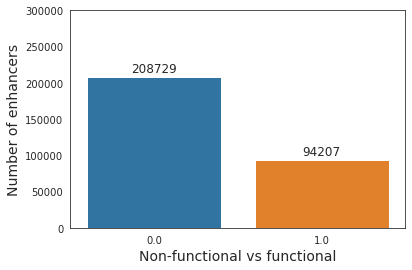

In [22]:
sns.set_style("white")
g = sns.countplot(data=OLS_data, x="MPRA_FXN")

for bar in g.patches:
    g.annotate(
        format(bar.get_height(), "d"),
        (bar.get_x() + bar.get_width() / 2, bar.get_height()),
        ha="center",
        va="center",
        xytext=(0, 8),
        textcoords="offset points",
        size=12,
    )

plt.ylim((0, 300000))
plt.xlabel("Non-functional vs functional", size=14)
plt.ylabel("Number of enhancers", size=14)
plt.savefig("figs/{}_class-balance.png".format(PREPROCESS))

### **Q3** What are the different spacings and orientations that I have?

*Total enhancers profiled*

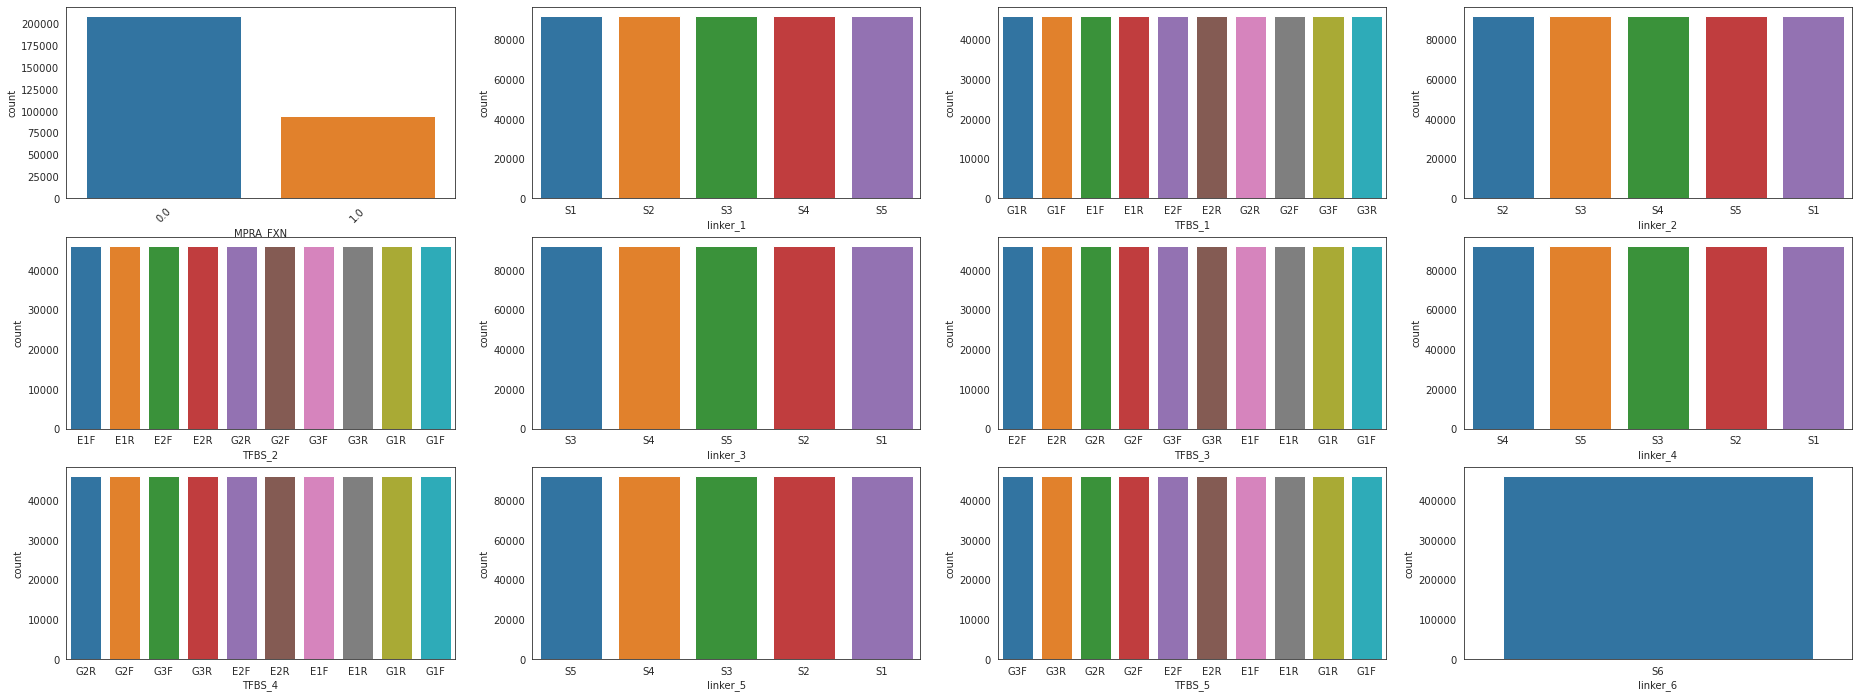

In [23]:
# Plot the number of each feature in each block as countplots with seaborn
num_rows, num_cols = 3, 4
fig, ax = plt.subplots(3, 4, figsize=(32, 12))
index = 0
for col in ["MPRA_FXN"] + block_features:
    row_num = int(index / num_cols)
    col_num = index % num_cols
    sns.countplot(data=OLS_data, x=col, ax=ax[row_num][col_num])
    if index == 0:
        ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=45)
    index += 1

*Joe's high confidence enhancers (Acitivity outside the range (0.18-0.40)*

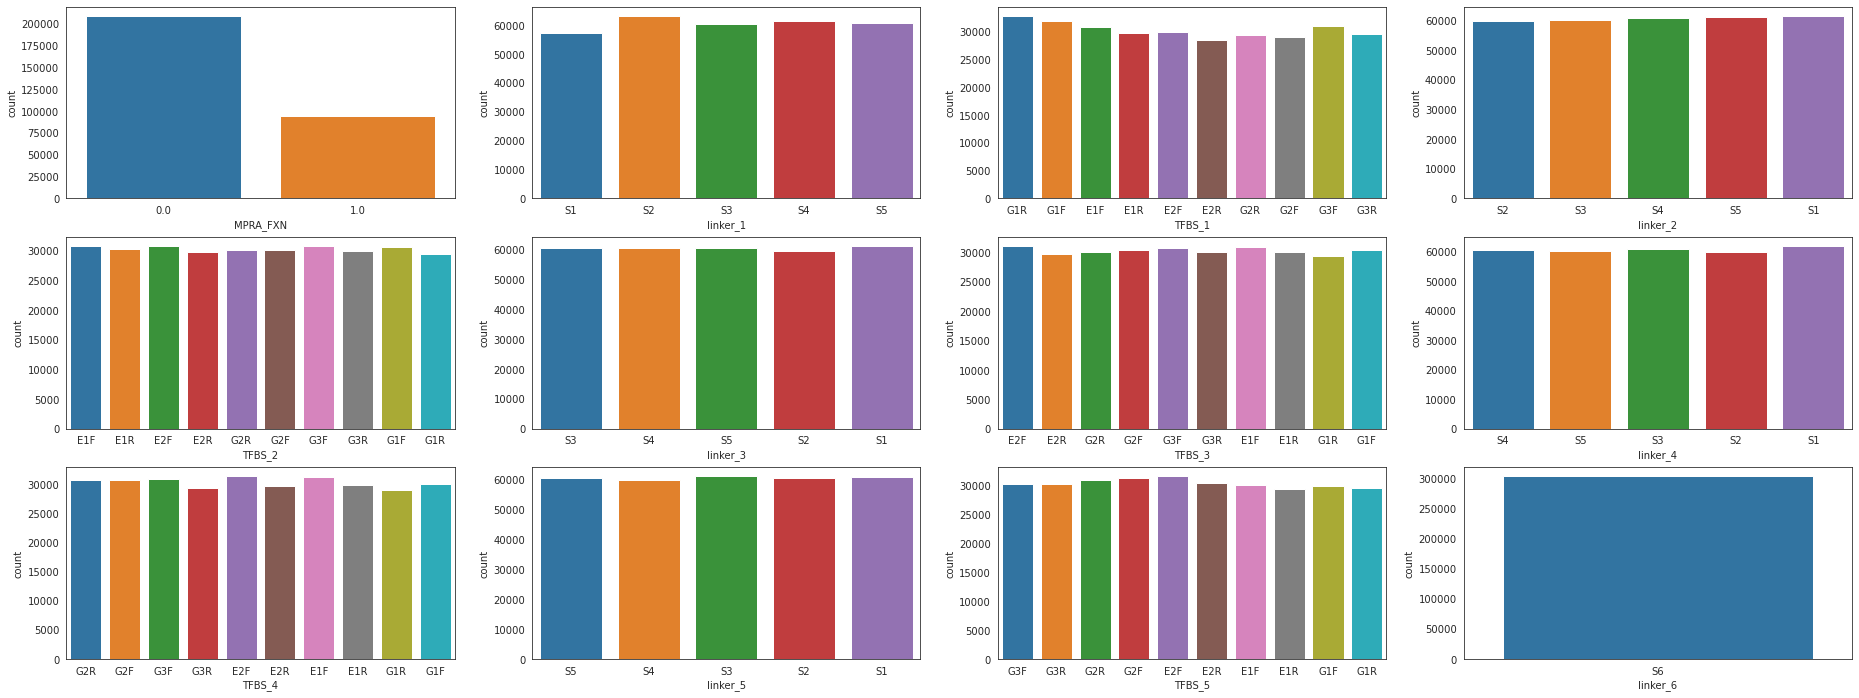

In [24]:
# Plot the number of each feature in each block as countplots with seaborn
num_rows, num_cols = 3, 4
fig, ax = plt.subplots(3, 4, figsize=(32, 12))
index = 0
for col in ["MPRA_FXN"] + block_features:
    row_num = int(index / num_cols)
    col_num = index % num_cols
    sns.countplot(
        data=OLS_data[~OLS_data["MPRA_FXN"].isna()], x=col, ax=ax[row_num][col_num]
    )
    index += 1
plt.savefig("figs/0.18-0.4_feature-counts.png")

*My own set threshold for high confidence enhancers (see Set-up section)*

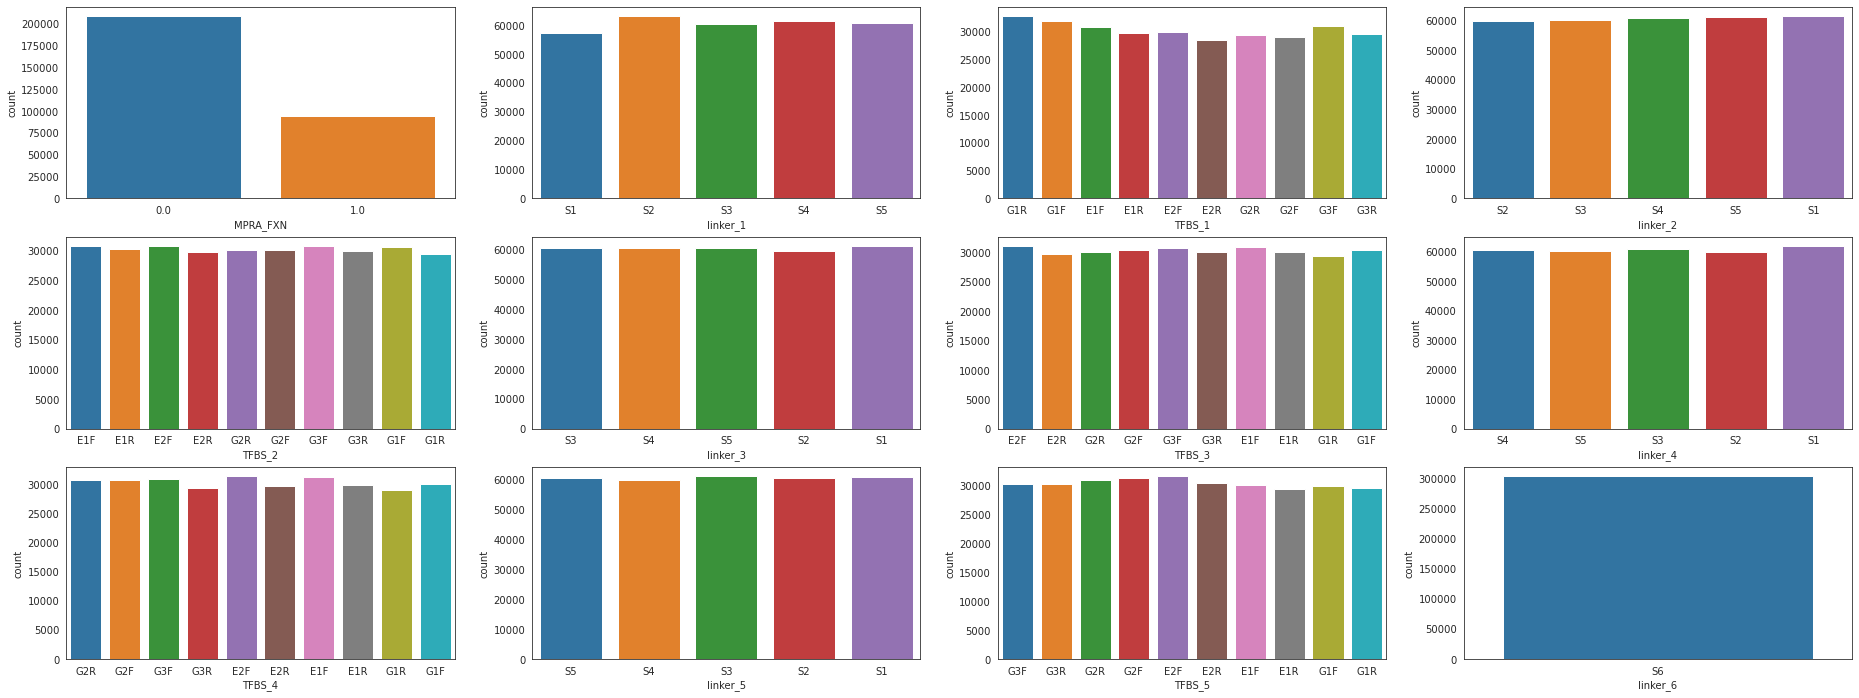

In [25]:
# Plot the number of each feature in each block as countplots with seaborn
num_rows, num_cols = 3, 4
fig, ax = plt.subplots(3, 4, figsize=(32, 12))
index = 0
for col in ["MPRA_FXN"] + block_features:
    row_num = int(index / num_cols)
    col_num = index % num_cols
    sns.countplot(
        data=OLS_data[~OLS_data["label"].isna()], x=col, ax=ax[row_num][col_num]
    )
    index += 1
plt.savefig("figs/{}_feature-counts.png".format(PREPROCESS))

### **Q4** Are different features associated with functionality?

In [26]:
# Sanity check to print to user which set of thresholds they are using
if(((OLS_data["ACTIVITY_SUMRNA_NUMDNA"] <= ACTIVE_LOW) | (OLS_data["ACTIVITY_SUMRNA_NUMDNA"] >= ACTIVE_HIGH)) == (~OLS_data["MPRA_FXN"].isna())).all():
    print("Using Joe's filter of removing activities between {} and {}".format(ACTIVE_LOW, ACTIVE_HIGH))
    OLS_data = OLS_data[~OLS_data["MPRA_FXN"].isna()]
else:
    print("Using own filter of removing activities between {} and {}".format(ACTIVE_LOW, ACTIVE_HIGH))
    OLS_data = OLS_data[~OLS_data["label"].isna()]

Using Joe's filter of removing activities between 0.18 and 0.4


linker_1


100it [00:14,  6.77it/s]


TFBS_1


100it [00:19,  5.06it/s]


linker_2


100it [00:15,  6.34it/s]


TFBS_2


100it [00:19,  5.03it/s]


linker_3


100it [00:15,  6.35it/s]


TFBS_3


100it [00:19,  5.14it/s]


linker_4


100it [00:15,  6.42it/s]


TFBS_4


100it [00:20,  4.97it/s]


linker_5


100it [00:15,  6.40it/s]


TFBS_5


100it [00:19,  5.09it/s]


linker_6


1it [00:00,  6.77it/s]

Something is rotten in the state of Denmark


2it [00:00,  7.34it/s]

Something is rotten in the state of Denmark


3it [00:00,  7.55it/s]

Something is rotten in the state of Denmark


4it [00:00,  6.99it/s]

Something is rotten in the state of Denmark


5it [00:00,  7.29it/s]

Something is rotten in the state of Denmark


6it [00:00,  7.49it/s]

Something is rotten in the state of Denmark


7it [00:00,  7.60it/s]

Something is rotten in the state of Denmark


8it [00:01,  7.66it/s]

Something is rotten in the state of Denmark


9it [00:01,  7.73it/s]

Something is rotten in the state of Denmark


10it [00:01,  7.77it/s]

Something is rotten in the state of Denmark


11it [00:01,  7.82it/s]

Something is rotten in the state of Denmark


12it [00:01,  7.83it/s]

Something is rotten in the state of Denmark


13it [00:01,  7.85it/s]

Something is rotten in the state of Denmark


14it [00:01,  7.82it/s]

Something is rotten in the state of Denmark


15it [00:01,  7.83it/s]

Something is rotten in the state of Denmark


16it [00:02,  7.83it/s]

Something is rotten in the state of Denmark


17it [00:02,  7.83it/s]

Something is rotten in the state of Denmark


18it [00:02,  7.86it/s]

Something is rotten in the state of Denmark


19it [00:02,  7.85it/s]

Something is rotten in the state of Denmark


20it [00:02,  7.87it/s]

Something is rotten in the state of Denmark


21it [00:02,  7.88it/s]

Something is rotten in the state of Denmark


22it [00:02,  7.87it/s]

Something is rotten in the state of Denmark


23it [00:02,  7.85it/s]

Something is rotten in the state of Denmark


24it [00:03,  7.46it/s]

Something is rotten in the state of Denmark


25it [00:03,  7.59it/s]

Something is rotten in the state of Denmark


26it [00:03,  7.67it/s]

Something is rotten in the state of Denmark


27it [00:03,  7.73it/s]

Something is rotten in the state of Denmark


28it [00:03,  7.77it/s]

Something is rotten in the state of Denmark


29it [00:03,  7.80it/s]

Something is rotten in the state of Denmark


30it [00:03,  7.80it/s]

Something is rotten in the state of Denmark


31it [00:04,  7.80it/s]

Something is rotten in the state of Denmark


32it [00:04,  7.80it/s]

Something is rotten in the state of Denmark


33it [00:04,  7.81it/s]

Something is rotten in the state of Denmark


34it [00:04,  7.78it/s]

Something is rotten in the state of Denmark


35it [00:04,  7.22it/s]

Something is rotten in the state of Denmark


36it [00:04,  7.38it/s]

Something is rotten in the state of Denmark


37it [00:04,  7.48it/s]

Something is rotten in the state of Denmark


38it [00:04,  7.60it/s]

Something is rotten in the state of Denmark


39it [00:05,  7.69it/s]

Something is rotten in the state of Denmark


40it [00:05,  7.74it/s]

Something is rotten in the state of Denmark


41it [00:05,  7.41it/s]

Something is rotten in the state of Denmark


42it [00:05,  7.56it/s]

Something is rotten in the state of Denmark


43it [00:05,  7.66it/s]

Something is rotten in the state of Denmark


44it [00:05,  7.73it/s]

Something is rotten in the state of Denmark


45it [00:05,  7.77it/s]

Something is rotten in the state of Denmark


46it [00:05,  7.77it/s]

Something is rotten in the state of Denmark


47it [00:06,  7.78it/s]

Something is rotten in the state of Denmark


48it [00:06,  7.79it/s]

Something is rotten in the state of Denmark


49it [00:06,  7.81it/s]

Something is rotten in the state of Denmark


50it [00:06,  7.83it/s]

Something is rotten in the state of Denmark


51it [00:06,  7.85it/s]

Something is rotten in the state of Denmark


52it [00:06,  7.85it/s]

Something is rotten in the state of Denmark


53it [00:06,  7.85it/s]

Something is rotten in the state of Denmark


54it [00:07,  7.87it/s]

Something is rotten in the state of Denmark


55it [00:07,  7.89it/s]

Something is rotten in the state of Denmark


56it [00:07,  7.90it/s]

Something is rotten in the state of Denmark


57it [00:07,  7.88it/s]

Something is rotten in the state of Denmark


58it [00:07,  7.87it/s]

Something is rotten in the state of Denmark


59it [00:07,  7.89it/s]

Something is rotten in the state of Denmark


60it [00:07,  7.89it/s]

Something is rotten in the state of Denmark


61it [00:07,  7.89it/s]

Something is rotten in the state of Denmark


62it [00:08,  7.89it/s]

Something is rotten in the state of Denmark


63it [00:08,  7.86it/s]

Something is rotten in the state of Denmark


64it [00:08,  7.87it/s]

Something is rotten in the state of Denmark


65it [00:08,  7.69it/s]

Something is rotten in the state of Denmark


66it [00:08,  7.73it/s]

Something is rotten in the state of Denmark


67it [00:08,  7.79it/s]

Something is rotten in the state of Denmark


68it [00:08,  7.83it/s]

Something is rotten in the state of Denmark


69it [00:08,  7.84it/s]

Something is rotten in the state of Denmark


70it [00:09,  7.85it/s]

Something is rotten in the state of Denmark


71it [00:09,  7.86it/s]

Something is rotten in the state of Denmark


72it [00:09,  7.87it/s]

Something is rotten in the state of Denmark


73it [00:09,  7.86it/s]

Something is rotten in the state of Denmark


74it [00:09,  7.86it/s]

Something is rotten in the state of Denmark


75it [00:09,  7.87it/s]

Something is rotten in the state of Denmark


76it [00:09,  7.88it/s]

Something is rotten in the state of Denmark


77it [00:09,  7.88it/s]

Something is rotten in the state of Denmark


78it [00:10,  7.86it/s]

Something is rotten in the state of Denmark


79it [00:10,  8.14it/s]

Something is rotten in the state of Denmark


80it [00:10,  8.36it/s]

Something is rotten in the state of Denmark


81it [00:10,  8.54it/s]

Something is rotten in the state of Denmark


82it [00:10,  8.00it/s]

Something is rotten in the state of Denmark


83it [00:10,  8.26it/s]

Something is rotten in the state of Denmark


84it [00:10,  8.45it/s]

Something is rotten in the state of Denmark


85it [00:10,  8.16it/s]

Something is rotten in the state of Denmark


86it [00:11,  8.38it/s]

Something is rotten in the state of Denmark


87it [00:11,  8.54it/s]

Something is rotten in the state of Denmark


88it [00:11,  8.66it/s]

Something is rotten in the state of Denmark


89it [00:11,  8.71it/s]

Something is rotten in the state of Denmark


90it [00:11,  8.77it/s]

Something is rotten in the state of Denmark


91it [00:11,  8.79it/s]

Something is rotten in the state of Denmark


92it [00:11,  8.84it/s]

Something is rotten in the state of Denmark


93it [00:11,  8.84it/s]

Something is rotten in the state of Denmark


94it [00:11,  8.85it/s]

Something is rotten in the state of Denmark


95it [00:12,  8.82it/s]

Something is rotten in the state of Denmark


96it [00:12,  8.86it/s]

Something is rotten in the state of Denmark


97it [00:12,  8.86it/s]

Something is rotten in the state of Denmark


98it [00:12,  8.86it/s]

Something is rotten in the state of Denmark


99it [00:12,  8.02it/s]

Something is rotten in the state of Denmark


100it [00:12,  7.92it/s]

Something is rotten in the state of Denmark



/cellar/users/aklie/opt/miniconda3/envs/scratch/lib/python3.9/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Something is rotten in the state of Denmark
permuted_label


100it [00:06, 16.55it/s]


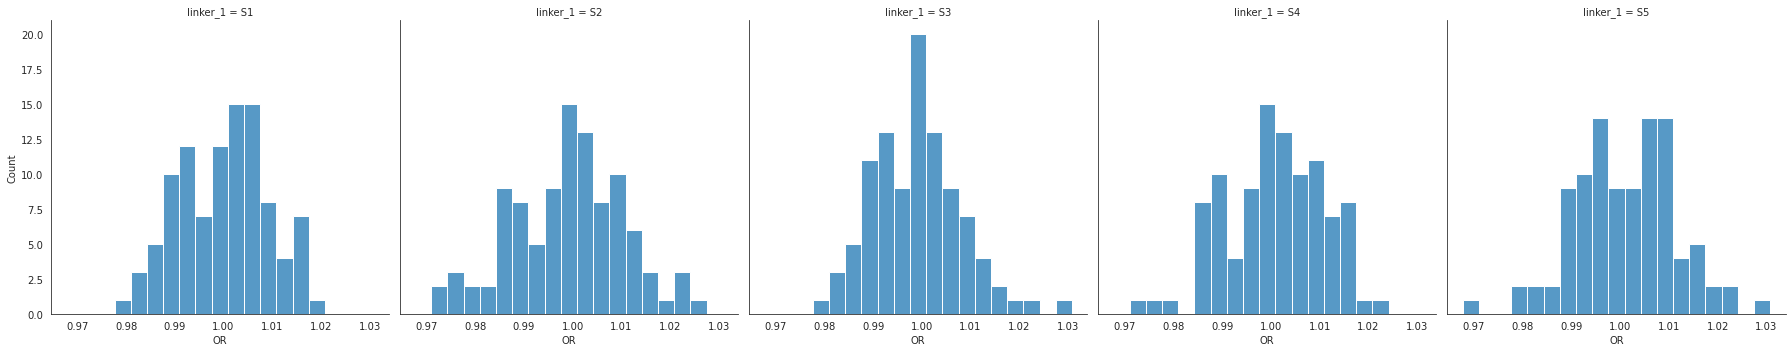

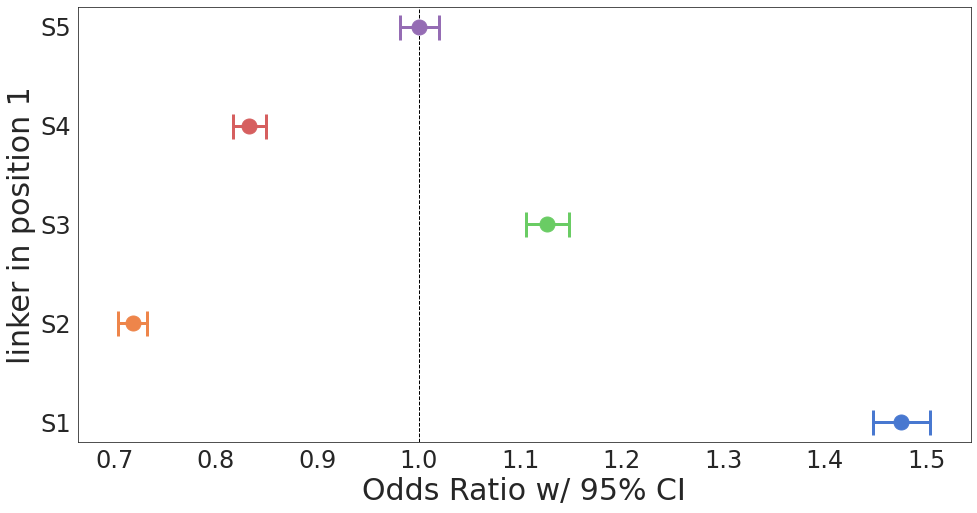

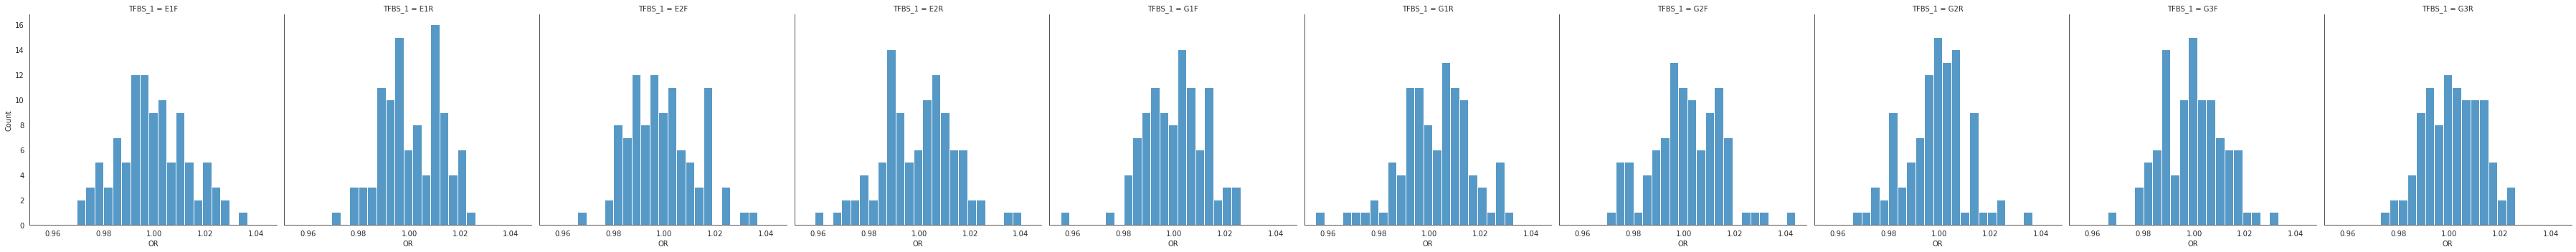

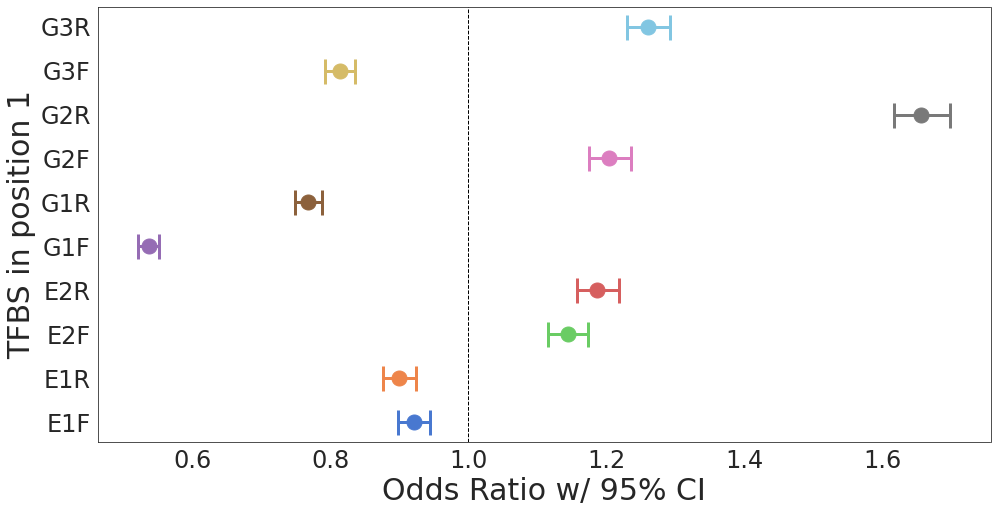

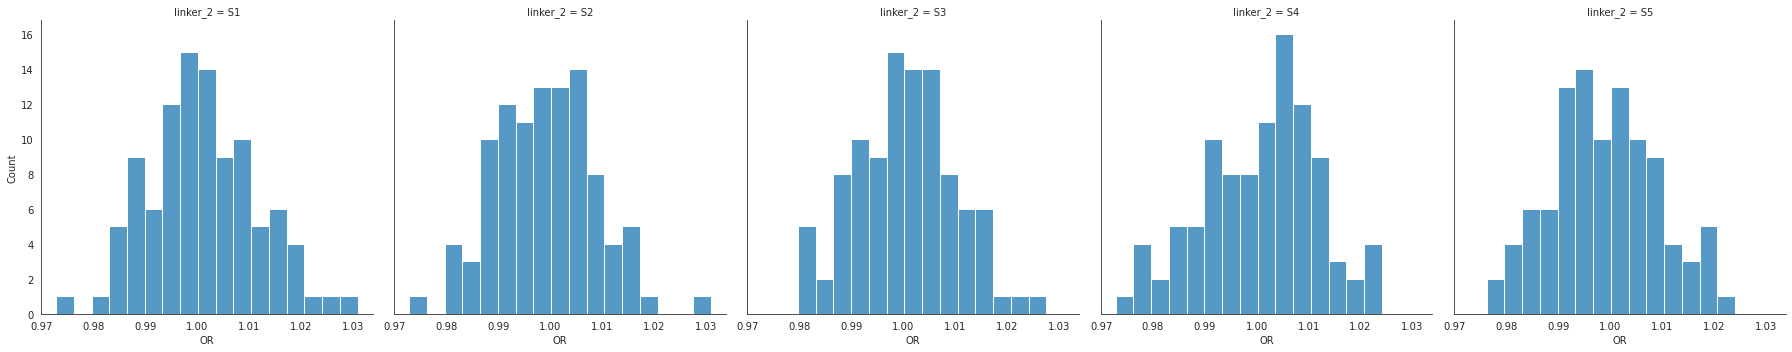

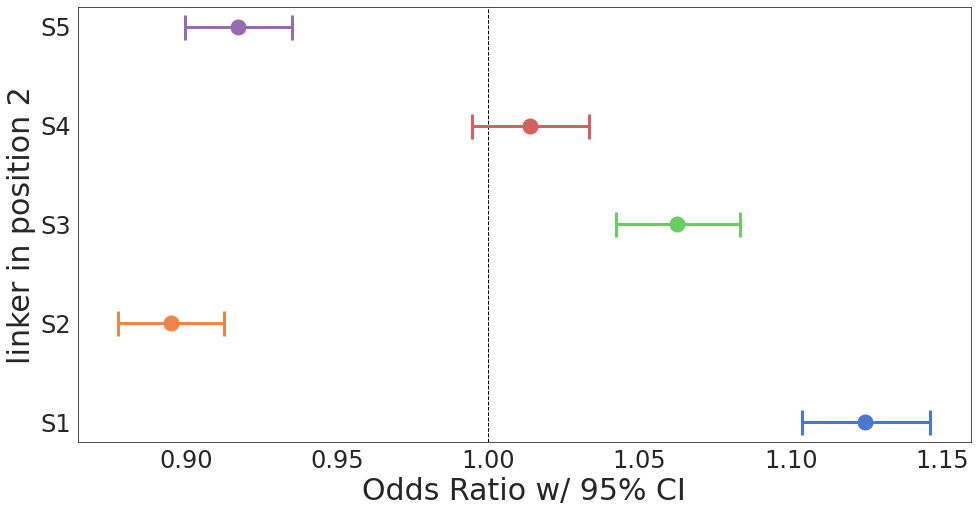

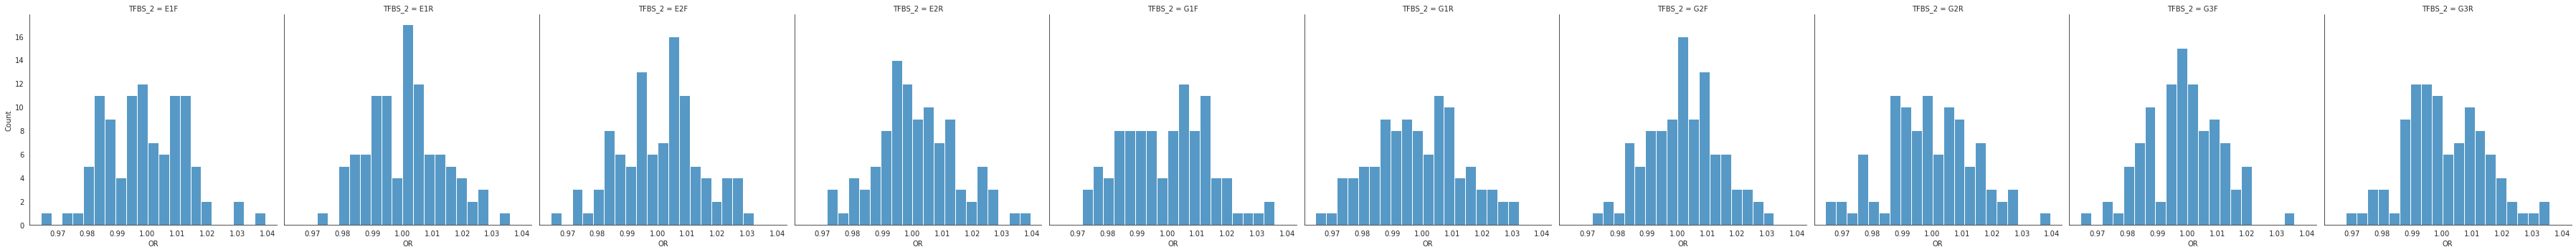

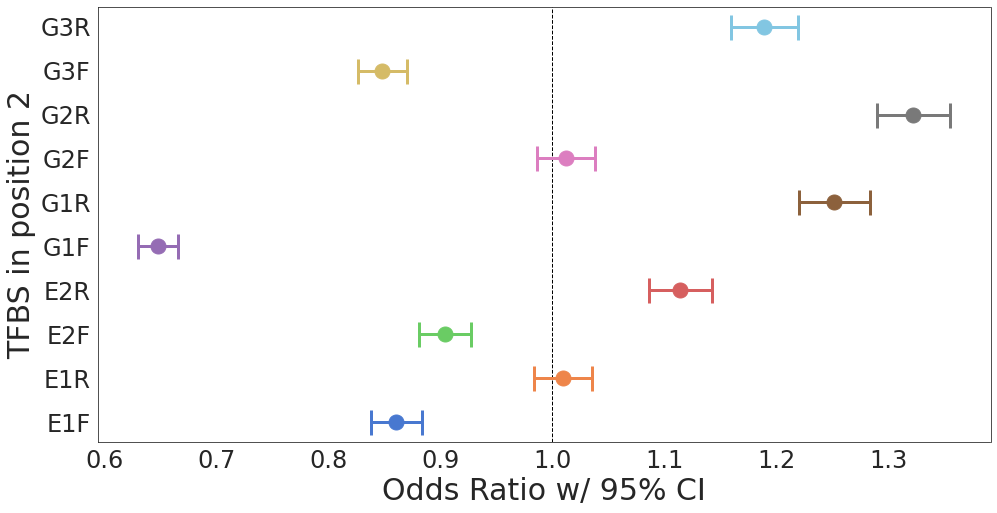

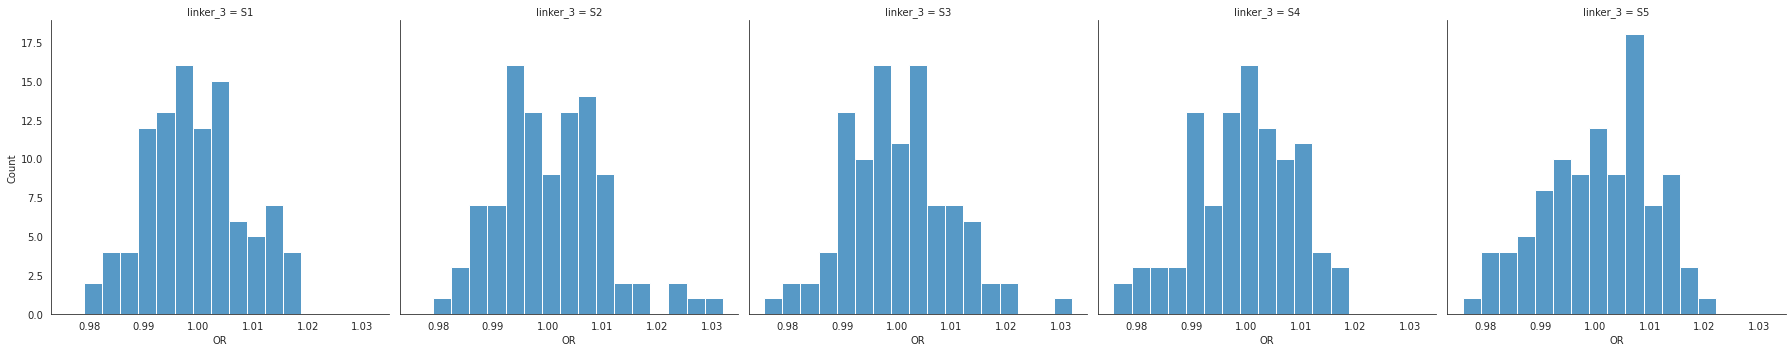

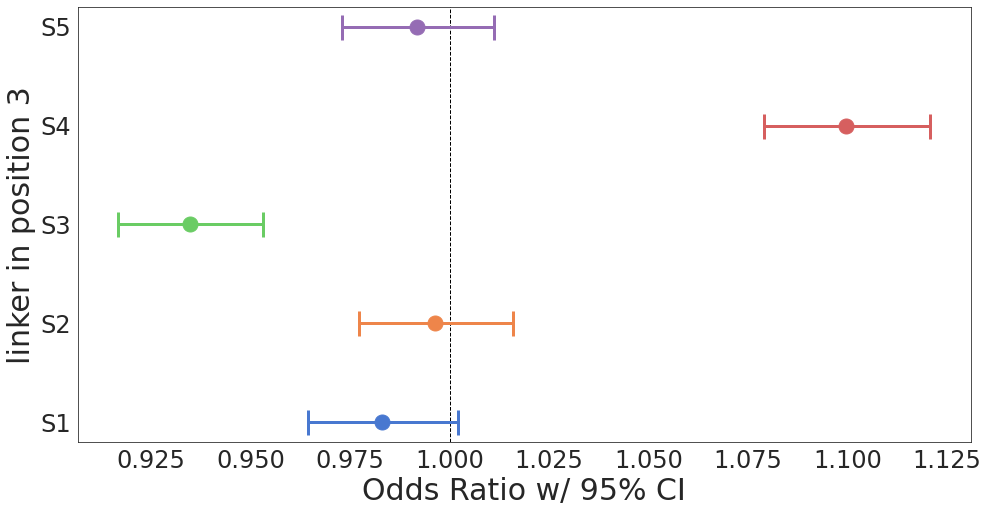

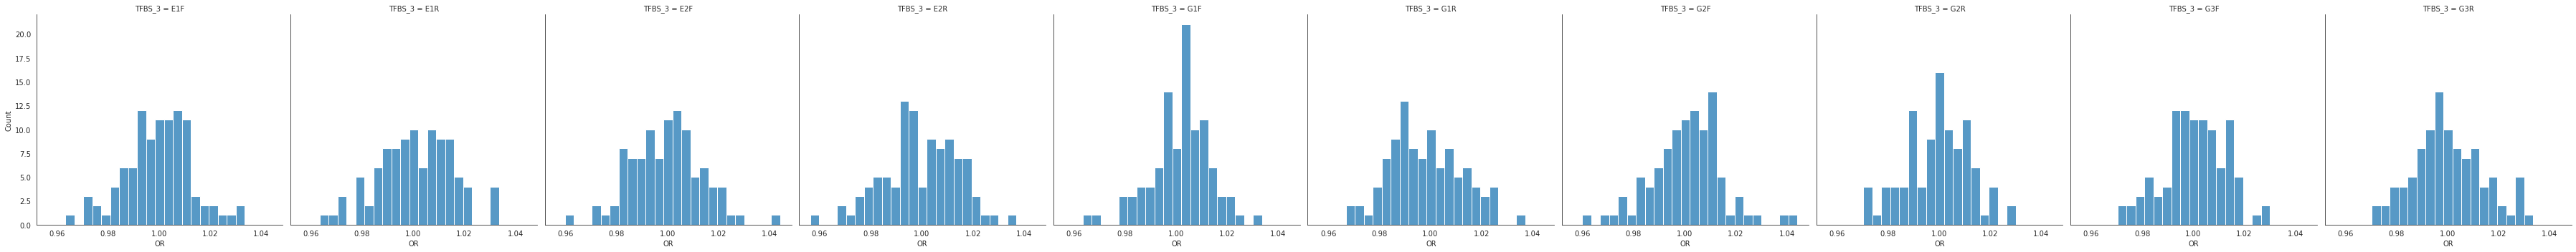

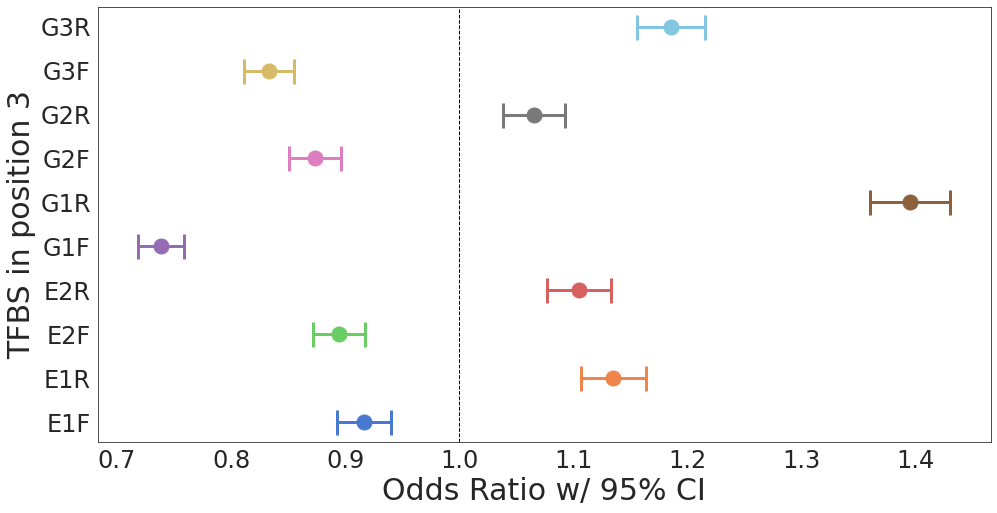

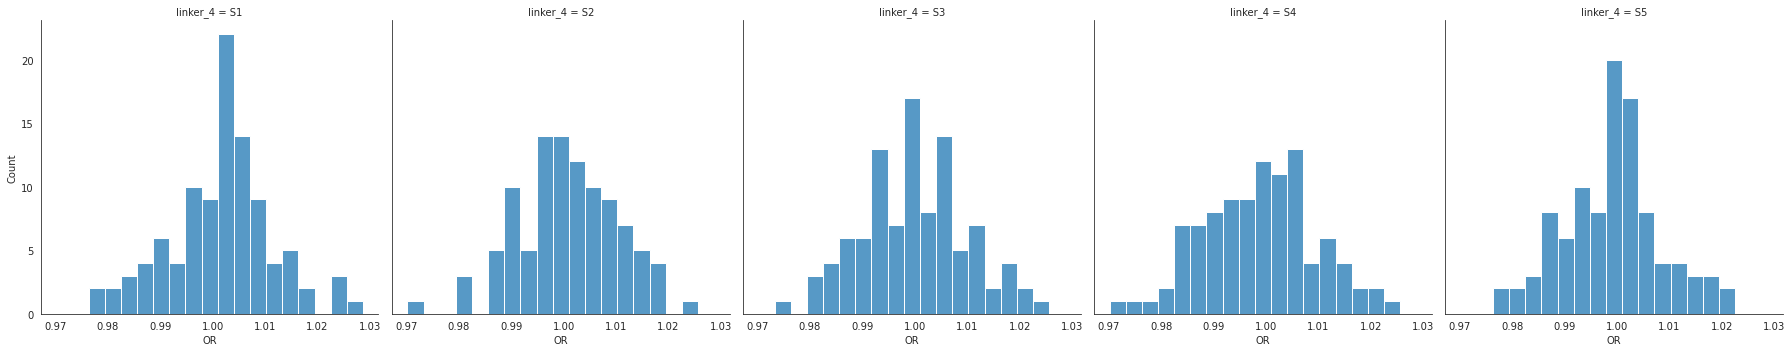

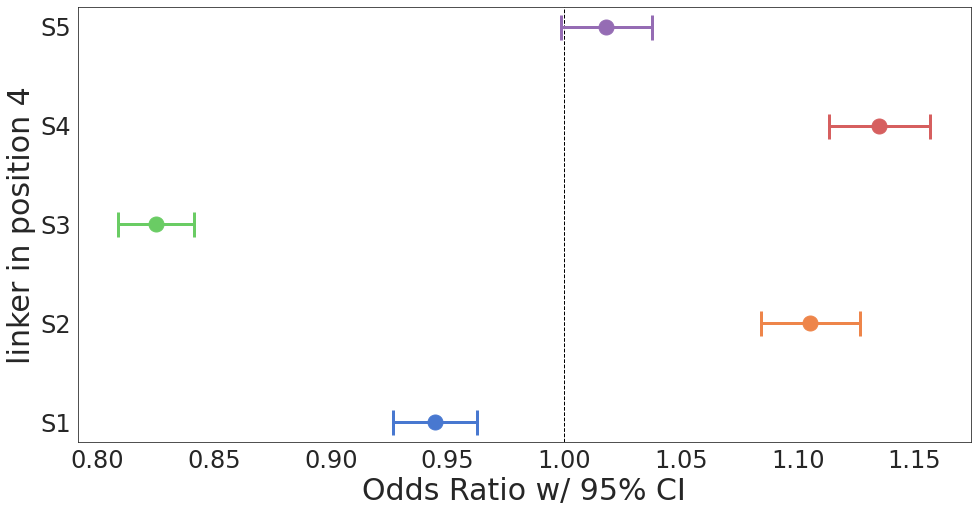

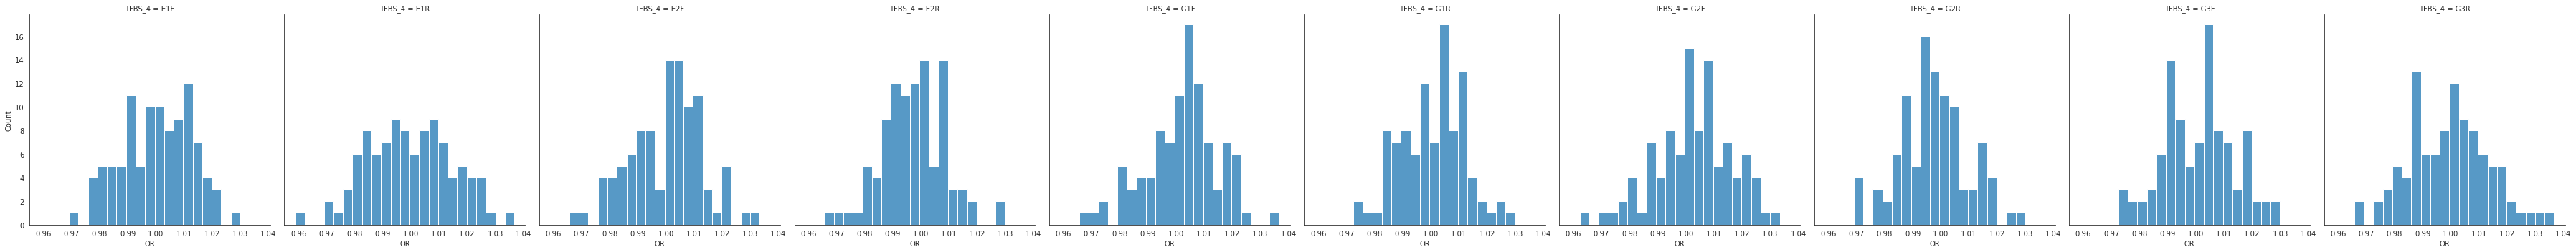

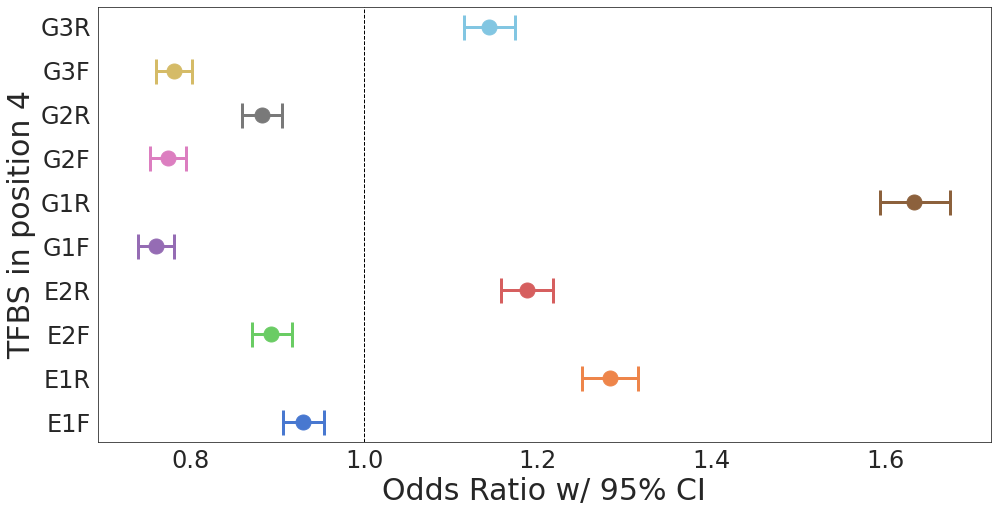

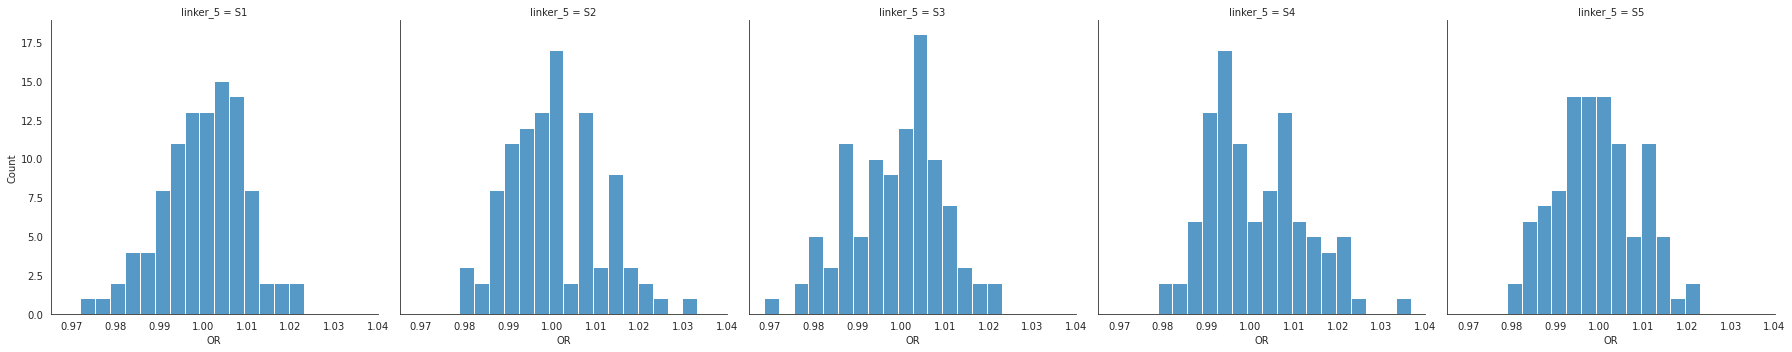

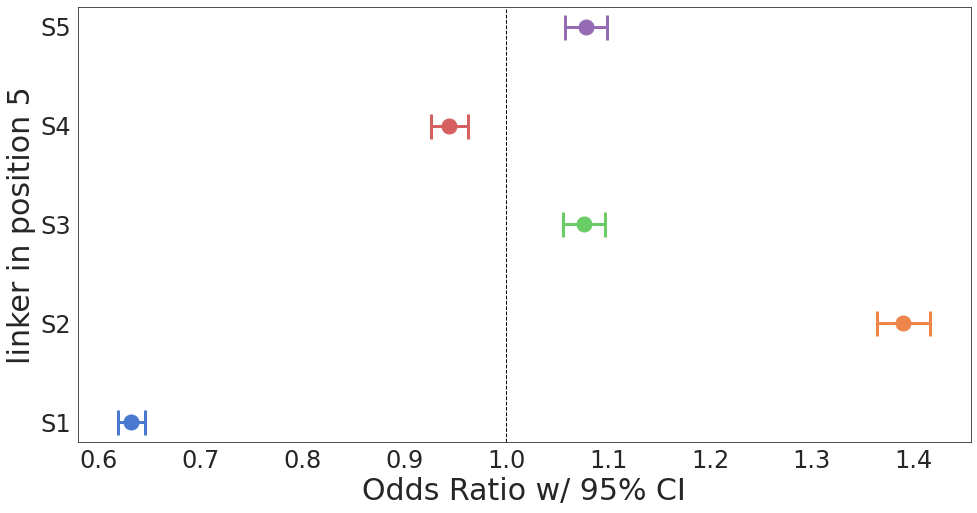

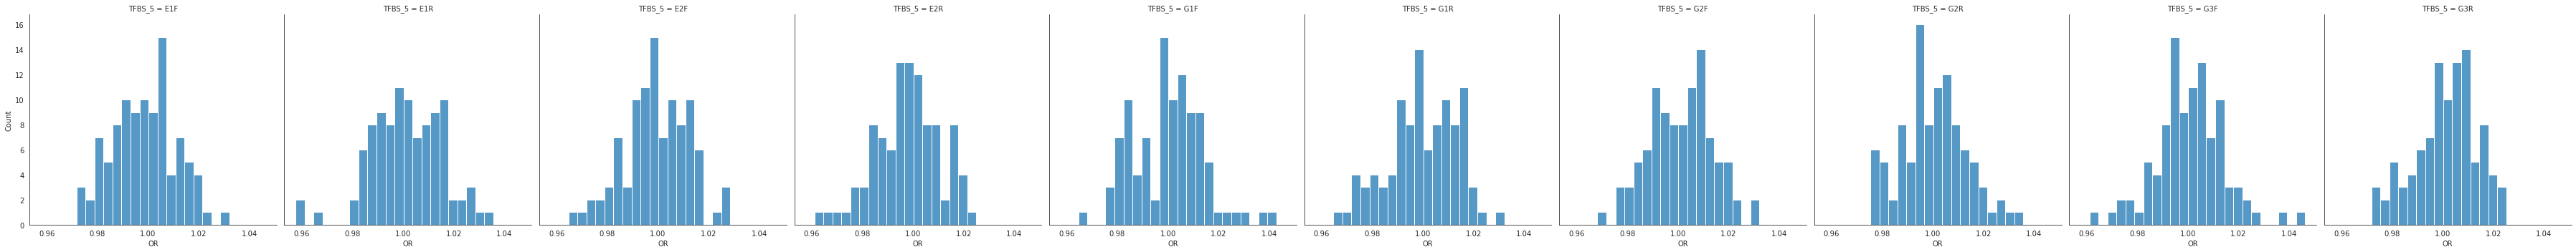

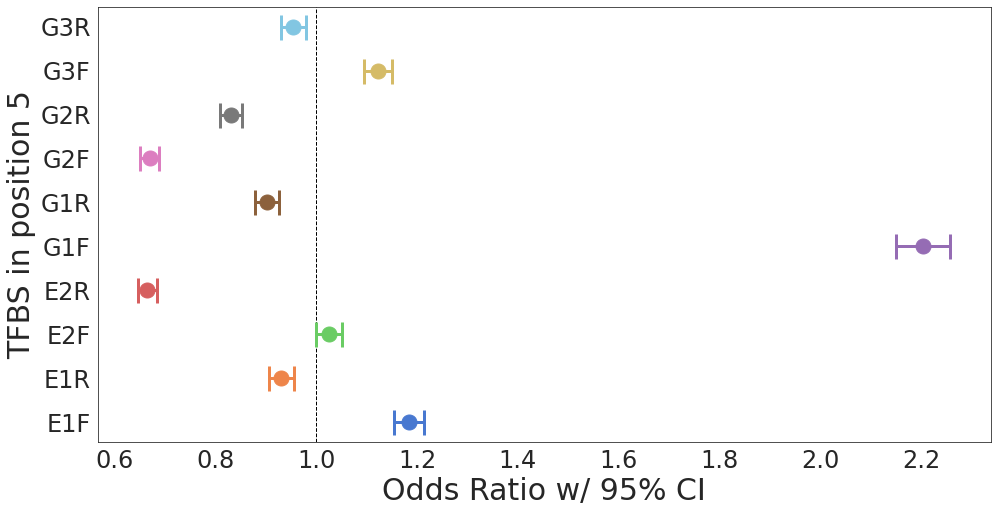

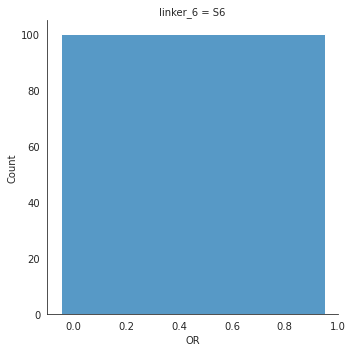

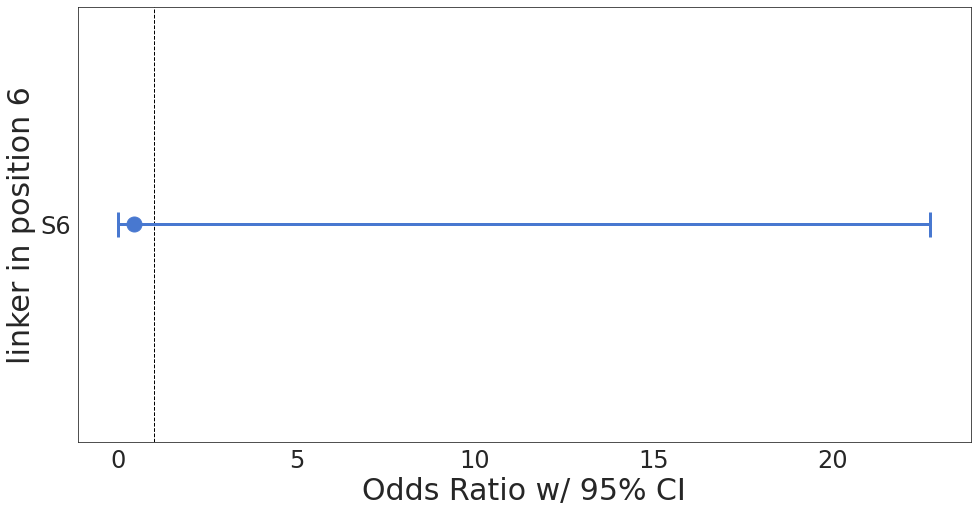

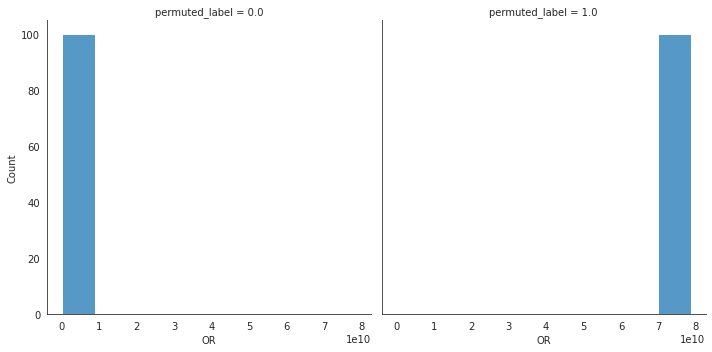

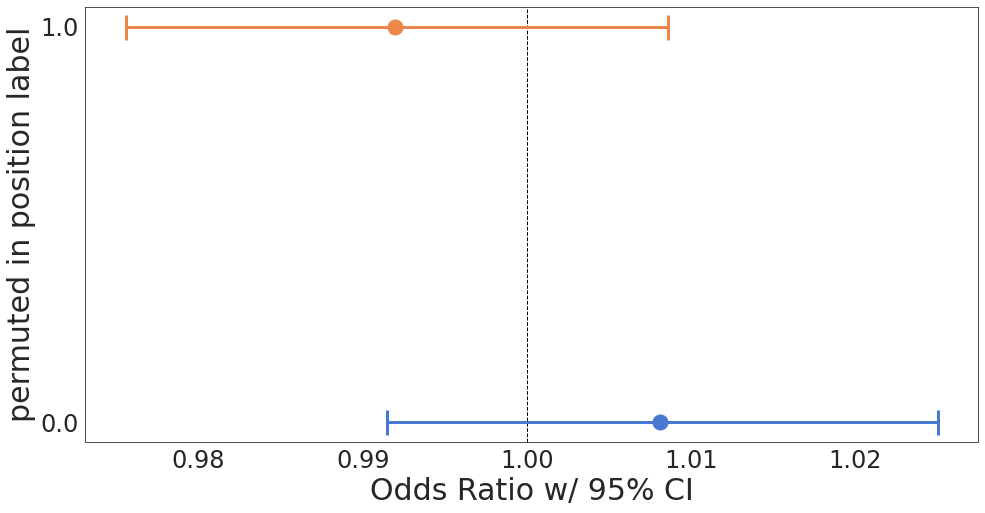

In [38]:
for curr_pos in OLS_data.columns[6:]:
    print(curr_pos)
    # Shuffle the labels and see what the odds ratios are
    permutes = 100
    permuted_odds = pd.DataFrame()
    for index, val in tqdm.tqdm(enumerate(range(permutes))):
        OLS_data["permuted_label"] = np.random.permutation(OLS_data["label"].values)
        odds_df = project_utils.odds_ratios(data=OLS_data, label="permuted_label", col=curr_pos)
        permuted_odds = permuted_odds.append(pd.DataFrame(odds_df["OR"]).reset_index())
    sns.displot(permuted_odds, x="OR", col=curr_pos, facet_kws=dict(margin_titles=True))
    plt.savefig("figs/odds_ratios/{}_{}_permuted-odds.png".format(PREPROCESS, curr_pos))

    # Calculate the true odds ratios and plot them
    odds_df = project_utils.odds_ratios(data=OLS_data, label="label", col=curr_pos)
    project_utils.plot_odds_ratios(odds_df=odds_df, col=curr_pos, savefig="figs/odds_ratios/{}_{}_real-odds.png".format(PREPROCESS, curr_pos))

## Processed data
EDA of the features engineered from this provided dataset

### Define parameters

In [59]:
FEATURES = "mixed-2.0"  # What features to use to train the model
PREPROCESS = "0.18-0.4"  # Preprocessing steps, separated by "-"

### Load data

In [60]:
X = np.loadtxt('{0}/X_{1}_{2}.txt'.format(FEATURES.replace("-", "_"), FEATURES, PREPROCESS), dtype=float)

In [61]:
y = np.loadtxt('y_binary_{}.txt'.format(PREPROCESS), dtype=int)
IDs = np.loadtxt('sequence_id_{}.txt'.format(PREPROCESS), dtype=str)
dataframe = pd.read_csv("20210728-3.EnhancerTable.ForAdam.FunctionalEnhancers.WT-detected.ABL-notDetected.10R-20U-0.1P.tsv", sep="\t", na_values="na")
IDs[0], X[0], y[0], IDs.shape, X.shape, y.shape

('S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6',
 array([12. ,  0. ,  0. ,  0.9, -1. ,  2. ,  0.6,  1. ,  0. ,  0. ,  7. ,
         0.4,  1. ,  0. ,  0. ,  5. ,  0. ,  0. ,  0.3, -1. ,  0. ,  0. ,
         0. ,  0.5,  1. ,  0. ]),
 1,
 (302936,),
 (302936, 26),
 (302936,))

In [62]:
dataframe = dataframe[~dataframe["MPRA_FXN"].isna()].set_index("NAME")
dataframe.head(1)

,SEQUENCE,MPRA_FXN,MICROSCOPE_FXN,ACTIVITY_SUMRNA_NUMDNA
NAME,,,,
S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,1.0,Neural Enhancer,0.611767


## **Train/test split**

In [63]:
X_train, X_test, y_train, y_test, IDs_train, IDs_test = train_test_split(X, y, IDs, train_size=0.9, random_state=13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, IDs_train.shape, IDs_test.shape

((272642, 26), (30294, 26), (272642,), (30294,), (272642,), (30294,))

In [64]:
np.unique(y_train, return_counts=True)[1]/len(y_train), np.unique(y_test, return_counts=True)[1]/len(y_test)

(array([0.68878236, 0.31121764]), array([0.69115997, 0.30884003]))

In [65]:
file = "{0}/{1}_header.txt".format(FEATURES.replace("-", "_"), FEATURES)
with open(file, "r") as f:
    features = [line.rstrip() for line in f.readlines()]

## Make dataframes

In [66]:
df = pd.DataFrame(X, columns=features, index=IDs)
df = pd.merge(dataframe, df, left_index=True, right_index=True)

In [67]:
train_df = pd.DataFrame(X_train, columns=features, index=IDs_train)
train_df = pd.merge(dataframe, train_df, left_index=True, right_index=True)

In [68]:
test_df = pd.DataFrame(X_test, columns=features, index=IDs_test)
test_df = pd.merge(dataframe, test_df, left_index=True, right_index=True)

## Let PandasProfiler take a stab at it
Description

In [69]:
profile = ProfileReport(df, title='{}'.format(FEATURES), progress_bar=True, dark_mode=True)

In [70]:
profile.to_file('{}_{}_eda.html'.format(PREPROCESS, FEATURES))

Summarize dataset:   0%|          | 0/44 [00:00<?, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/ml_env/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/cellar/users/aklie/opt/miniconda3/envs/ml_env/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Check train and test distributions

/cellar/users/aklie/opt/miniconda3/envs/ml_env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


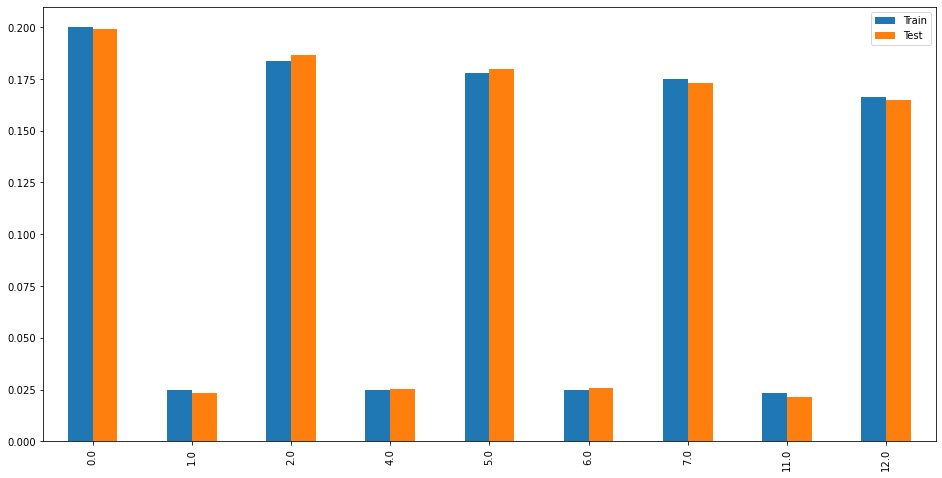

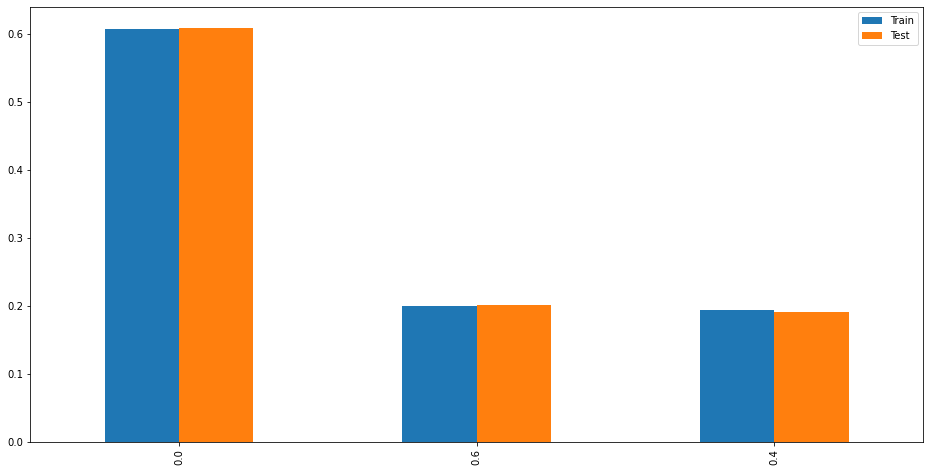

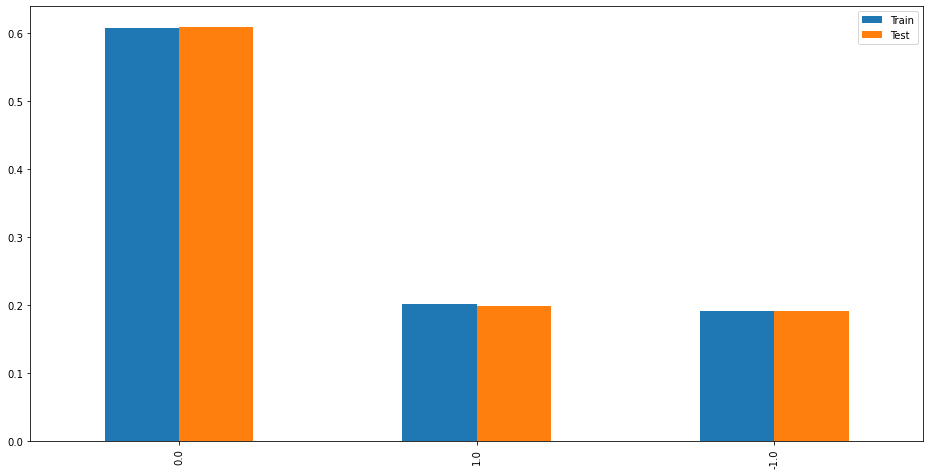

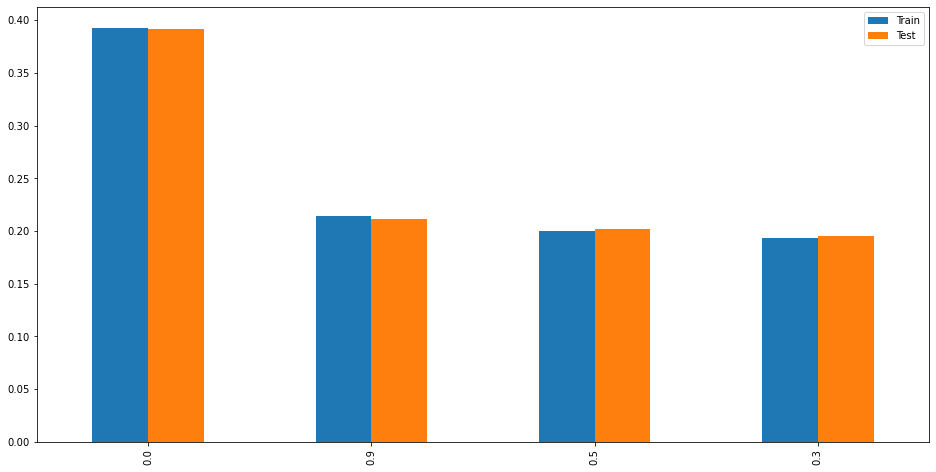

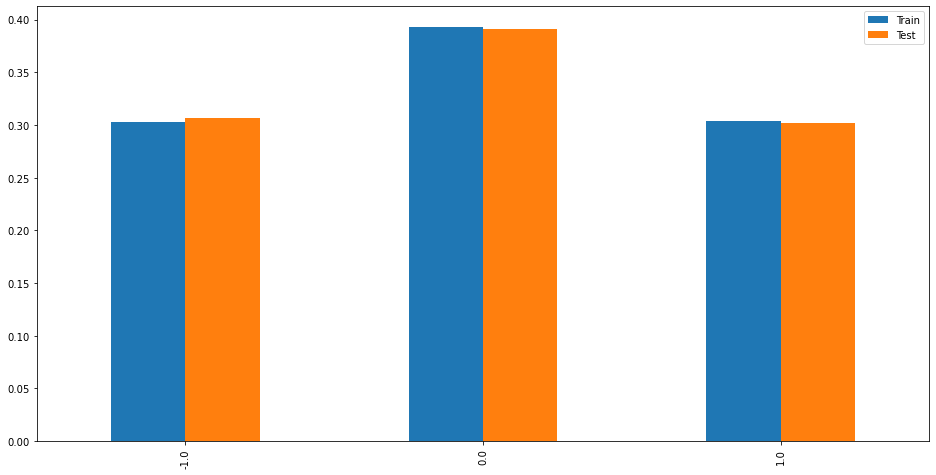

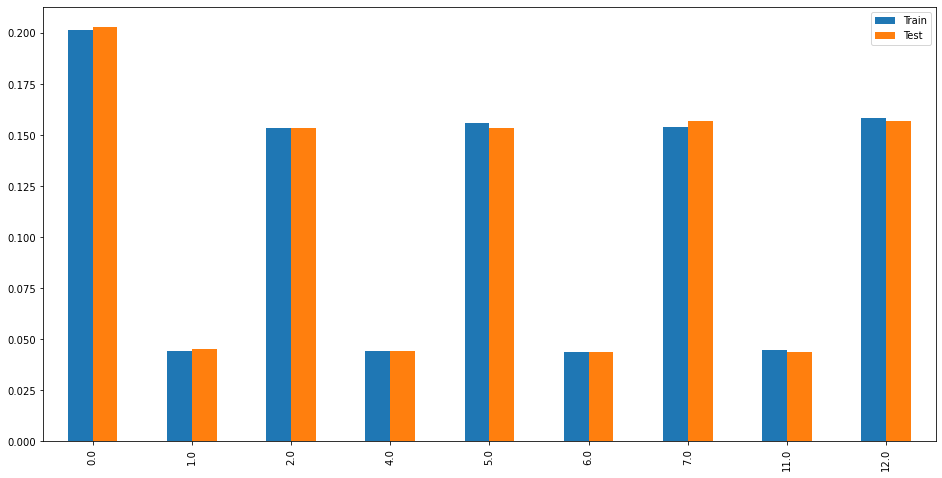

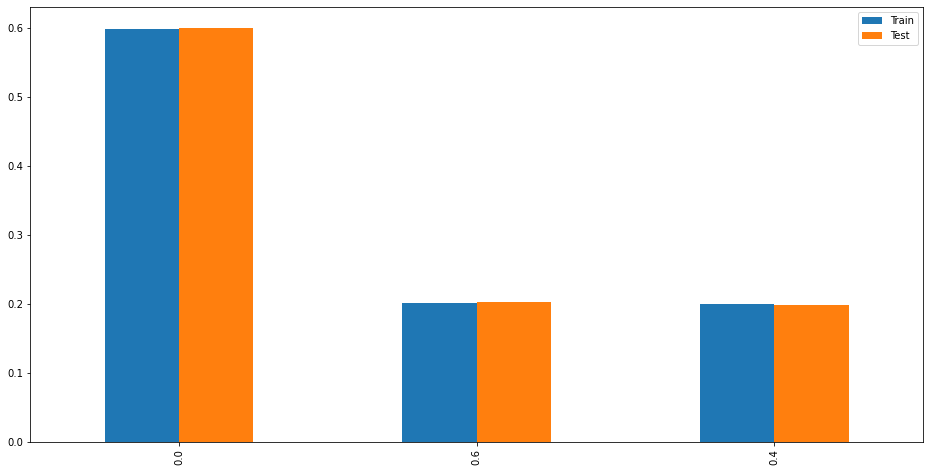

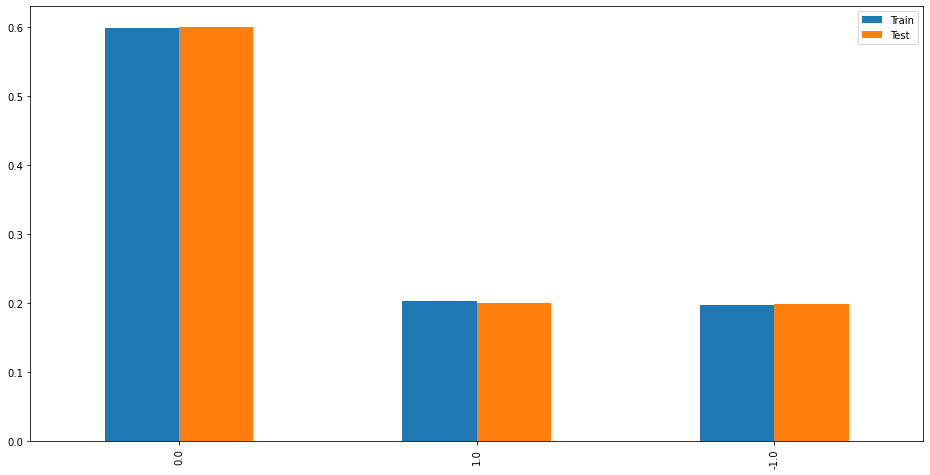

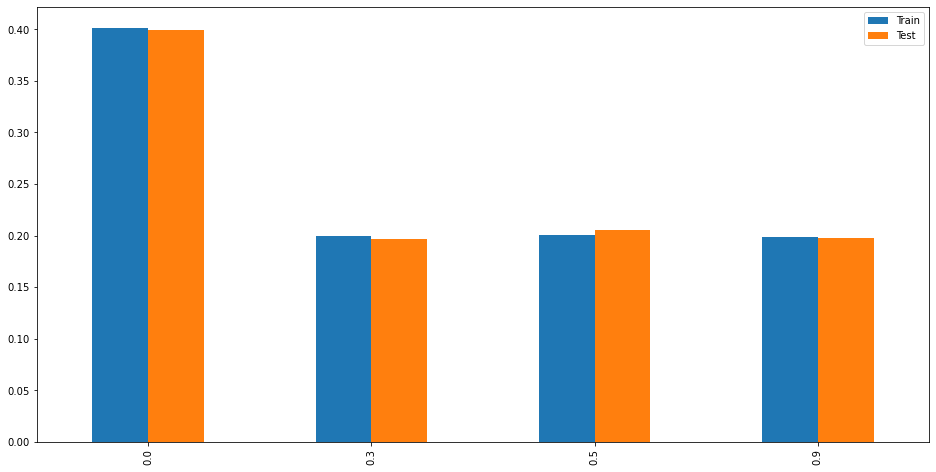

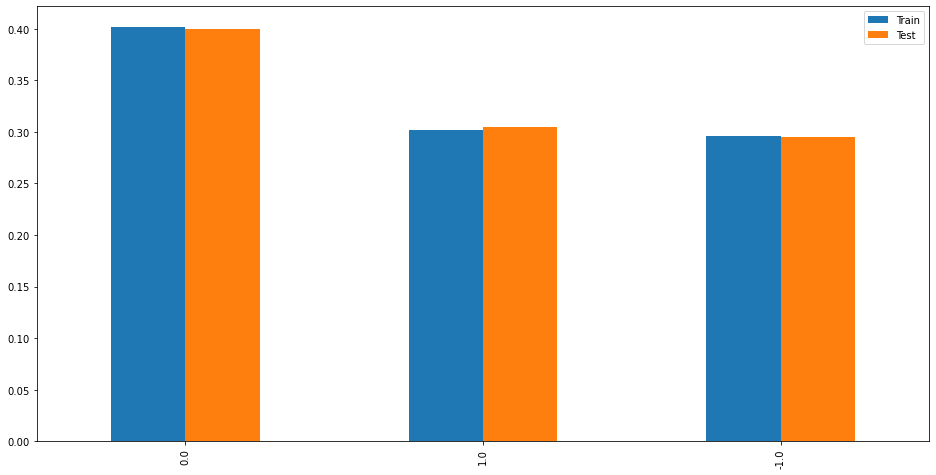

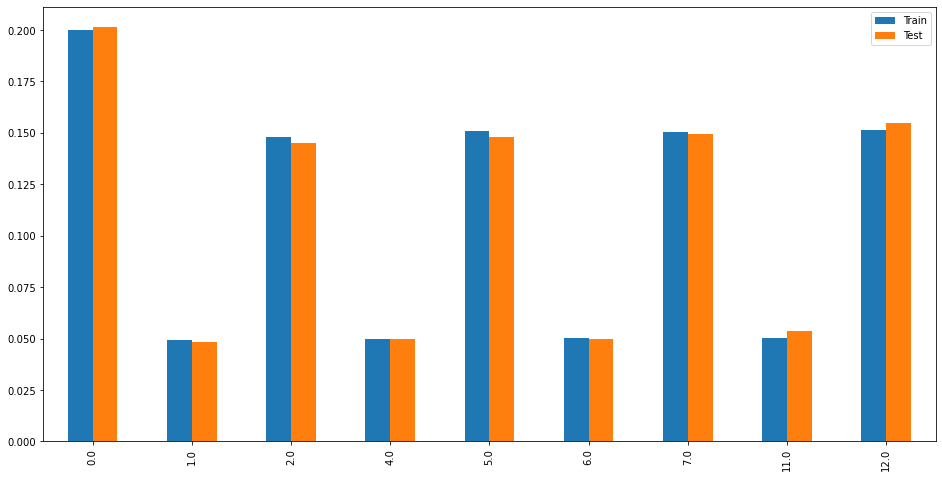

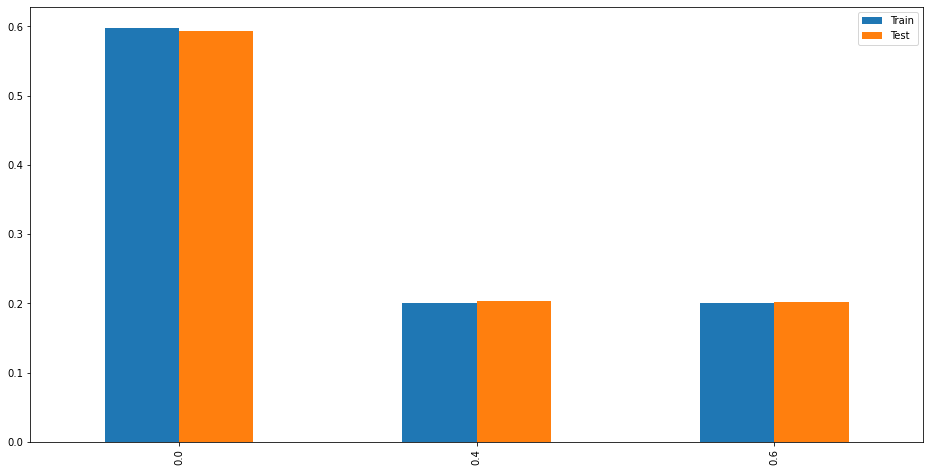

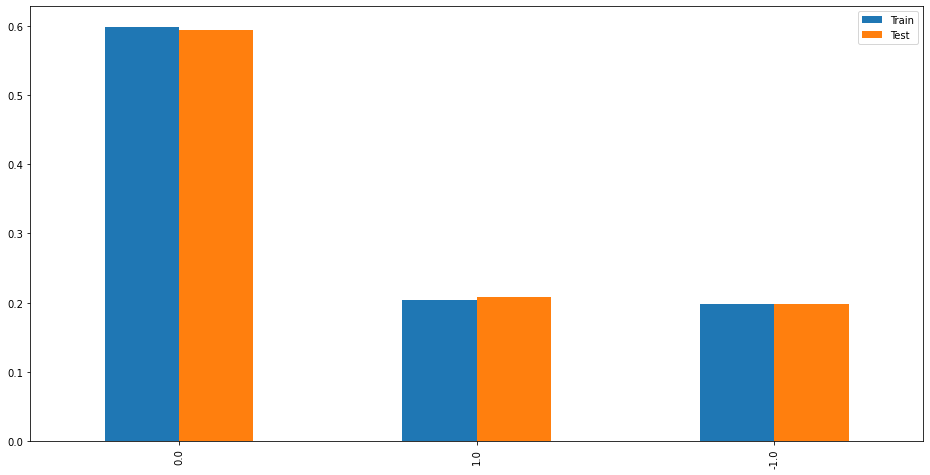

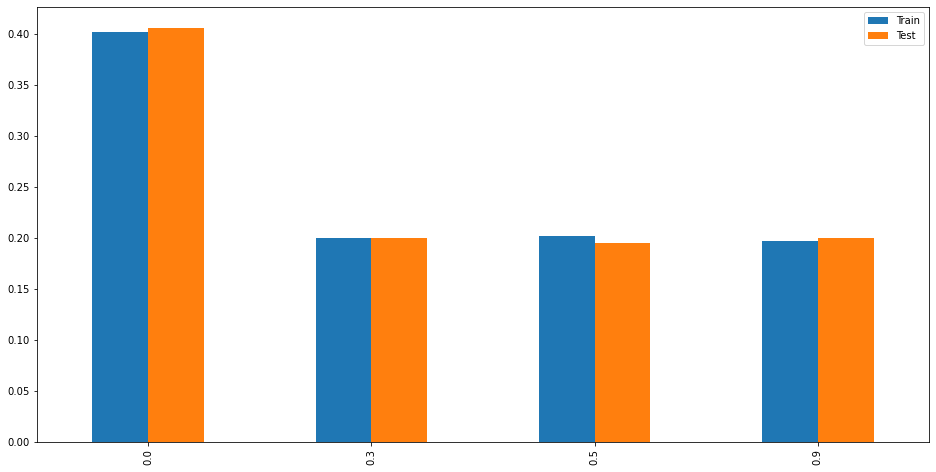

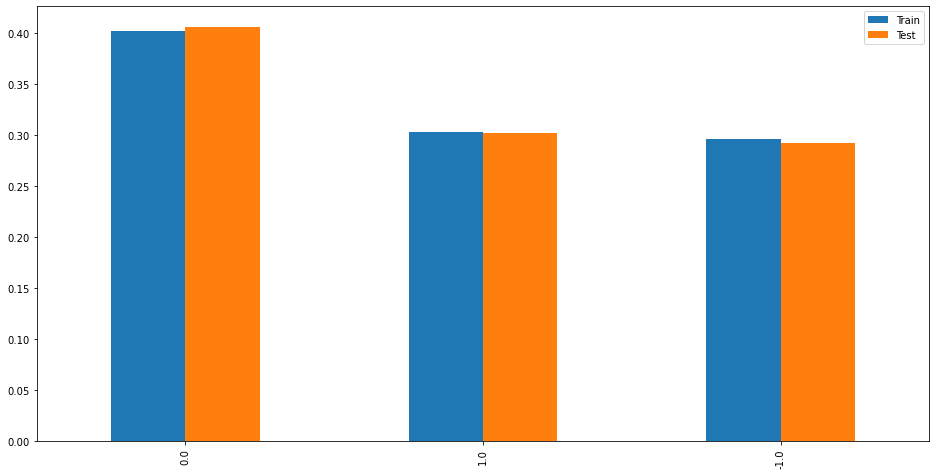

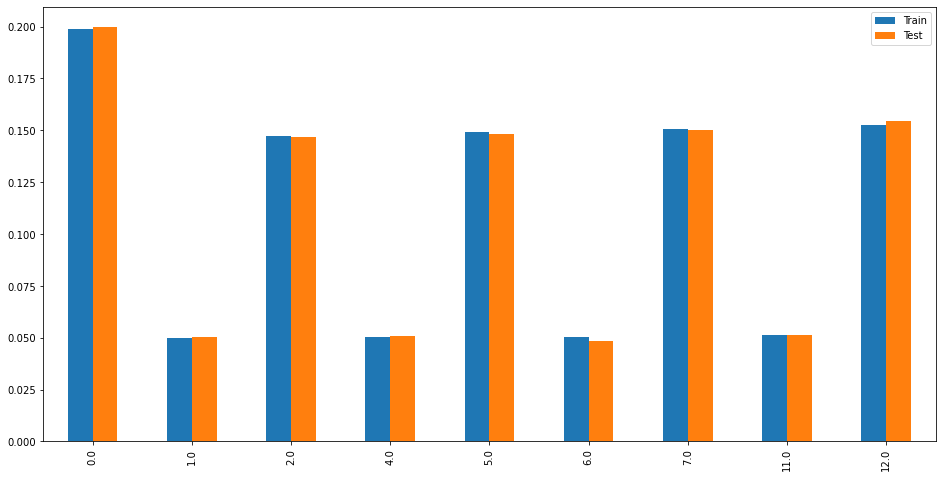

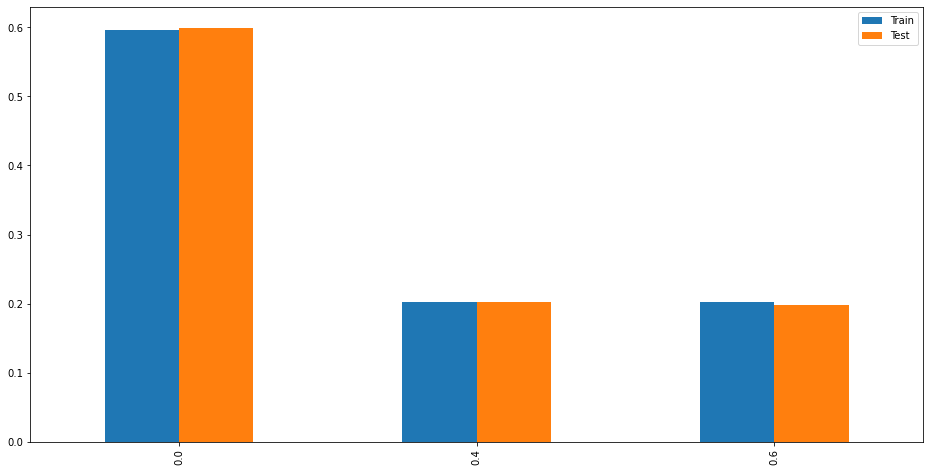

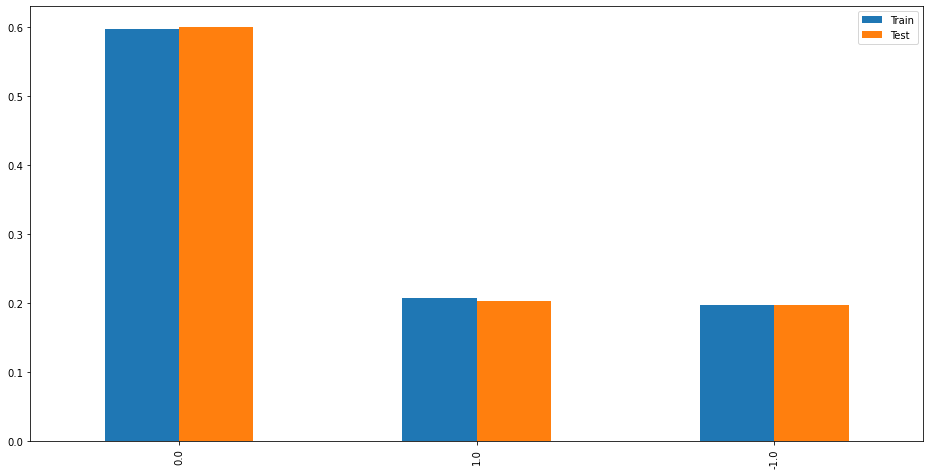

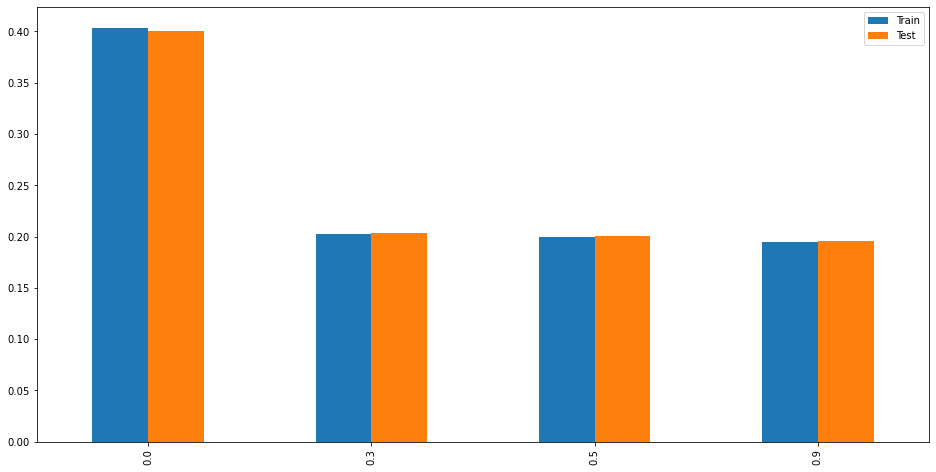

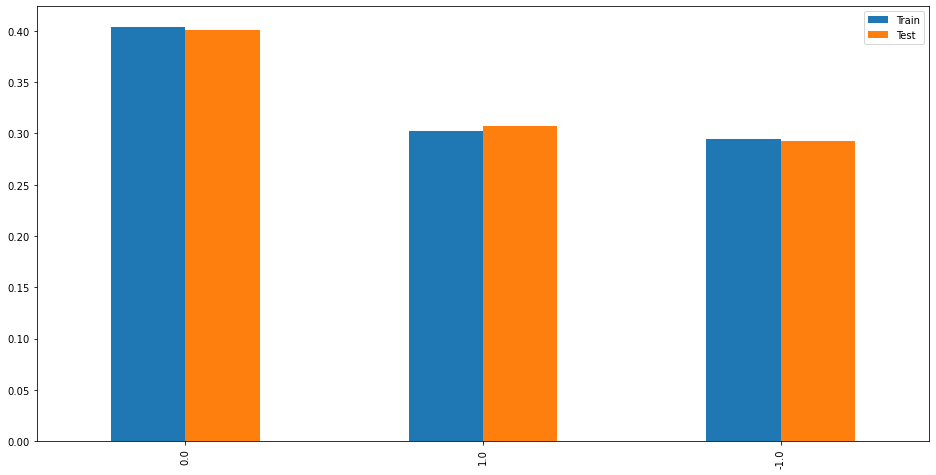

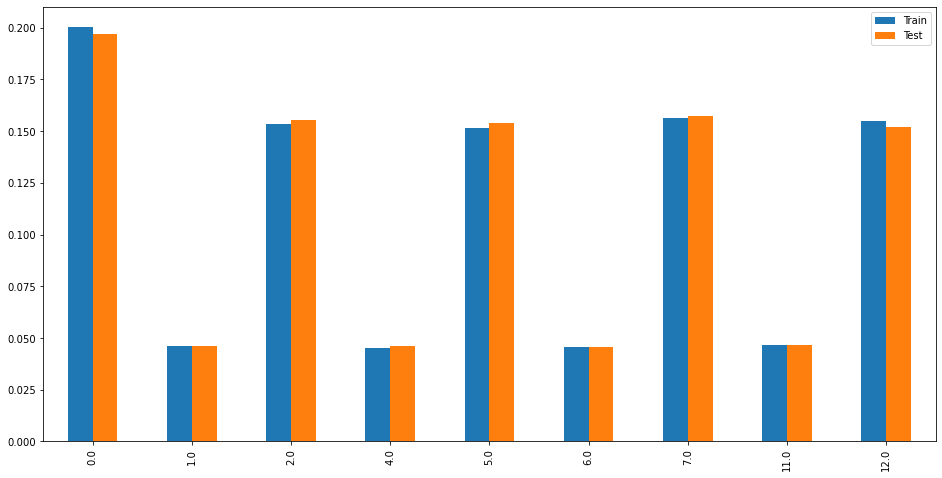

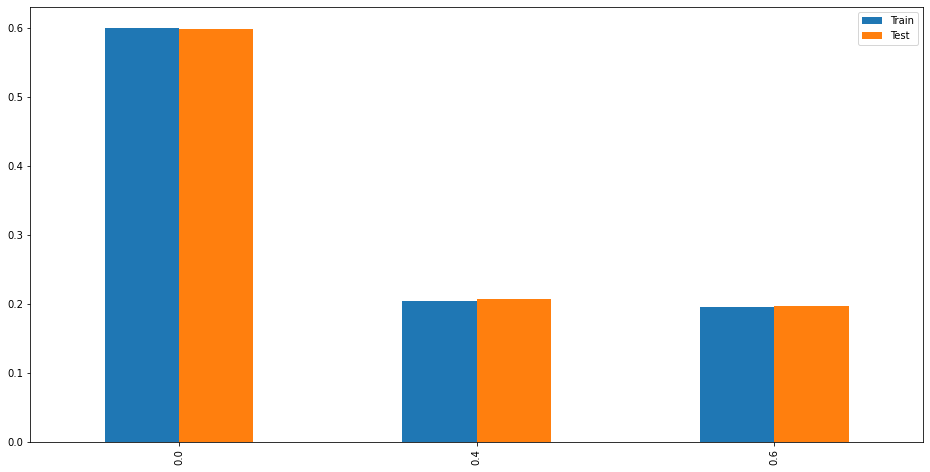

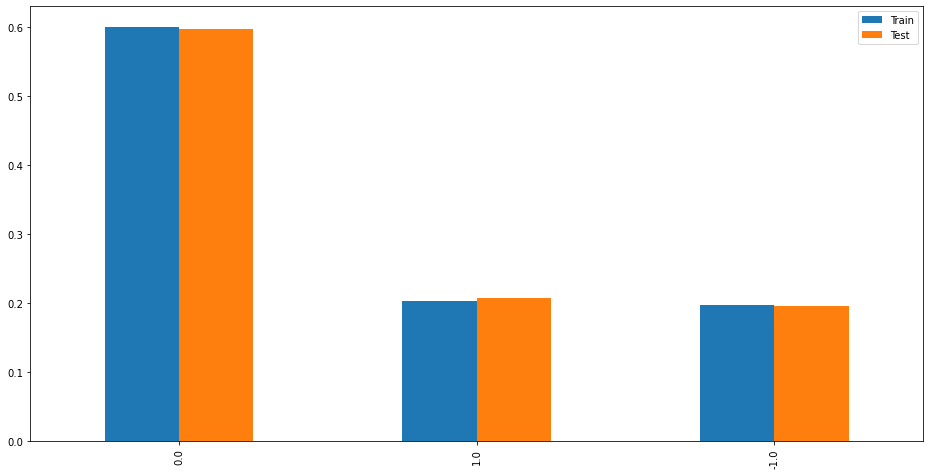

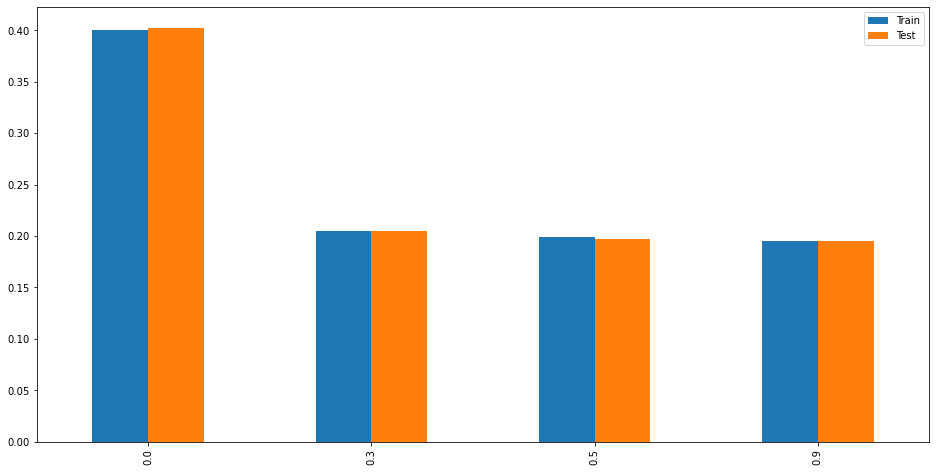

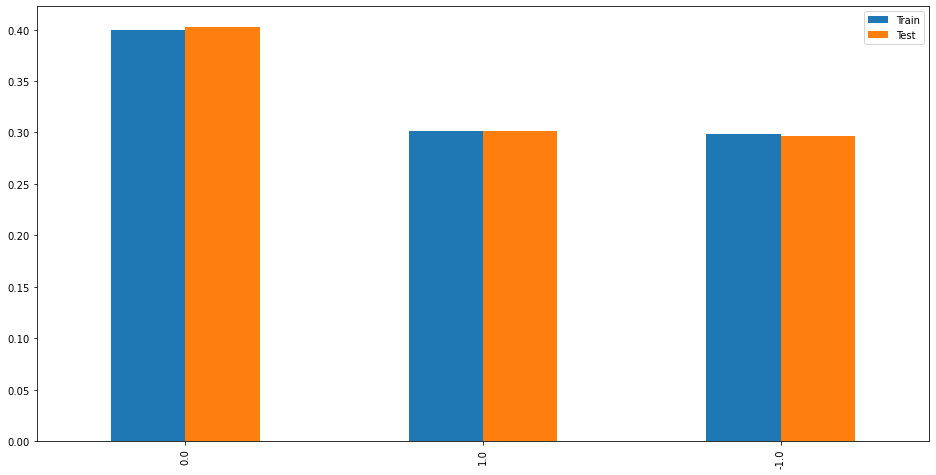

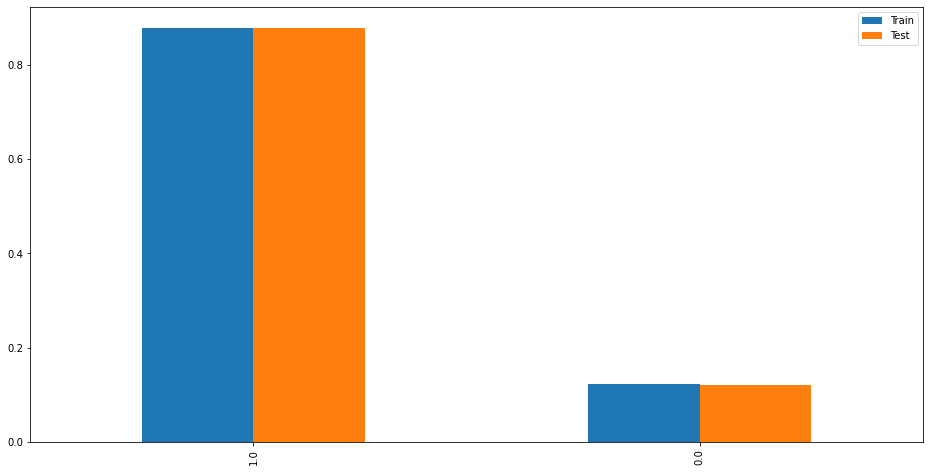

In [71]:
for col in features:
    col_train = train_df[col].value_counts(normalize=True)
    col_test = test_df[col].value_counts(normalize=True)
    col_perc = pd.concat([col_train, col_test], axis=1)
    col_perc.columns = ["Train", "Test"]
    col_perc.plot(kind="bar", figsize=(16,8))

# Scratch

## My turn

In [ ]:
num_rows, num_cols = 3, 7

fig, ax = plt.subplots(num_rows, num_cols, figsize=(40,24))
sns.set_theme(style="ticks", palette="pastel")

for i, col in enumerate(df.columns[:-1]):

    data = df.groupby("Response")[col].value_counts(normalize=True)
    data = data.mul(100).rename('percent').reset_index()
    sns.barplot(data=data, x=col, y='percent',hue="Response", palette=["m", "g"], ax=ax[int(i/num_cols)][i%num_cols])
                                                                                               
sns.despine(offset=10, trim=True)                                                                                  

In [ ]:
# Generate a contigency table for this position
cont_tbl = pd.crosstab(OLS_data["label"], OLS_data[curr_pos])
cont_tbl

In [ ]:
if (
    not (cont_tbl.sum(axis=1).values == OLS_data["label"].value_counts().values).all()
) or (
    not (
        np.array(sorted(cont_tbl.sum(axis=0).values))
        == np.array(sorted(OLS_data[curr_pos].value_counts().values))
    ).all()
):
    print("Something is rotten in the state of Denmark")

In [ ]:
# Build a statsmodels "Table" object
table = sm.stats.Table(cont_tbl)

**<u> (Observed - Expected) frequencies under indpendence assumption </u>**

In [ ]:
diff = table.table_orig - table.fittedvalues
diff

**<u> Pearson residuals (Observed - Expected)/(Expected^1/2) under indpendence assumption. </u>** This attempts to adjust for larger values of observed and expected

In [ ]:
# Calculate manually
resid_pearson = diff / (table.fittedvalues ** 0.5)
resid_pearson

In [ ]:
# Use statsmodels
table.resid_pearson

In [ ]:
# Note that this can be related to chi2 (http://people.musc.edu/~bandyopd/bmtry711.11/lecture_10.pdf)
(table.resid_pearson ** 2).values.sum()

**<u> Chi-2 test for independence</u>**

In [ ]:
rslt = table.test_nominal_association()

In [ ]:
rslt.statistic, rslt.pvalue

In [ ]:
# Double check with scipy
from scipy.stats import chi2_contingency

chi2, p, _, _ = chi2_contingency(cont_tbl)
chi2, p

**<u> Odds-ratios and plots </u>**

In [ ]:
project_utils.odds_ratio(cont_table=cont_tbl)

In [ ]:
# Defnie a CI and an empty dataframe to hold odds-ratio info
alpha = 0.05
odds_df = pd.DataFrame(
    columns=[
        "OR",
        "OR " + str(alpha * 100) + "%",
        "OR " + str((1 - alpha) * 100) + "%",
    ],
    index=cont_tbl.columns,
)

for col in cont_tbl.columns:
    tab = pd.concat([cont_tbl[col], cont_tbl.drop(col, axis=1).sum(axis=1)], axis=1)
    tab = tab.loc[[1, 0]]
    table = sm.stats.Table2x2(tab.values)
    if not (
        (
            table.table_orig.sum(axis=1)
            == OLS_data["label"].value_counts().loc[[1, 0]].values
        ).all()
    ):
        print("Something is rotten in the state of Denmark")
    odds_df.loc[col]["OR"] = table.oddsratio
    (
        odds_df.loc[col]["OR " + str(alpha * 100) + "%"],
        odds_df.loc[col]["OR " + str((1 - alpha) * 100) + "%"],
    ) = table.oddsratio_confint(0.05)

In [ ]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(16, 8))
ax.axvline(1, ls="--", linewidth=1, color="black")
# odds_df = np.log(odds_df.astype(float))

n = 0
for index, i in odds_df.iterrows():
    x = [i["OR 5.0%"], i["OR 95.0%"]]
    y = [n, n]
    ax.plot(
        x,
        y,
        "|",
        markersize=25,
        markeredgewidth=3,
        linewidth=3,
        color=sns.color_palette("muted")[n],
    )
    ax.plot(
        x,
        y,
        "-",
        markersize=25,
        markeredgewidth=3,
        linewidth=3,
        color=sns.color_palette("muted")[n],
    )

    y = [n]
    x = [i["OR"]]
    ax.plot(x, y, "o", color=sns.color_palette("muted")[n], markersize=15)
    n += 1

ax.set_ylabel(
    "{0} in position {1}".format(curr_pos.split("_")[0], curr_pos.split("_")[1]),
    fontsize=30,
)
ax.set_yticks(range(0, n))
ax.set_yticklabels(odds_df.index, fontsize=24)

ax.set_xlabel("Odds Ratio w/ 95% CI", fontsize=30)
ax.tick_params(axis="x", labelsize=24)
ax.text(
    odds_df["OR 95.0%"].max() + 0.05,
    n - 1.5,
    r"$\chi^{2} =$" + str(round(chi2, 2)),
    fontsize=36,
)
ax.text(odds_df["OR 95.0%"].max() + 0.05, n - 2.5, "P = {}".format(p), fontsize=36)
plt.savefig("figs/odds_ratios/{}-{}_{}.png".format(ACTIVE_LOW, ACTIVE_HIGH, curr_pos))

In [27]:
# Get all the possible positions and iterate
pos_iter = iter(OLS_data.columns[6:])

In [28]:
# Choose the next position
curr_pos = next(pos_iter)
curr_pos

'linker_1'

In [29]:
# Compute stats on contigency table
table, diff, resid_pearson, rslt = project_utils.contigency_table_stats(data=OLS_data, label="label", col=curr_pos)

100it [00:16,  6.02it/s]


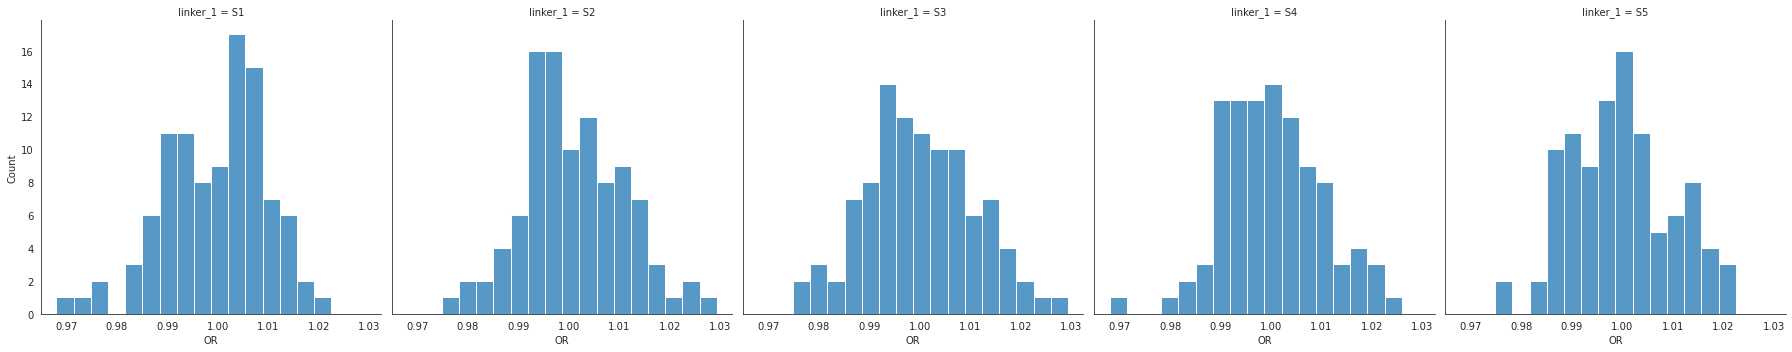

In [34]:
# Shuffle the labels and see what the odds ratios are
permutes = 100
permuted_odds = pd.DataFrame()
for index, val in tqdm.tqdm(enumerate(range(permutes))):
    OLS_data["permuted_label"] = np.random.permutation(OLS_data["label"].values)
    odds_df = project_utils.odds_ratios(data=OLS_data, label="permuted_label", col=curr_pos)
    permuted_odds = permuted_odds.append(pd.DataFrame(odds_df["OR"]).reset_index())
sns.displot(permuted_odds, x="OR", col=curr_pos, facet_kws=dict(margin_titles=True))
plt.savefig("figs/odds_ratios/{}_{}_permuted-odds.png".format(PREPROCESS, curr_pos))

# Calculate the true odds ratios and plot them
odds_df = project_utils.odds_ratios(data=OLS_data, label="label", col=curr_pos)
project_utils.plot_odds_ratios(odds_df=odds_df, col=curr_pos, savefig="figs/odds_ratios/{}_{}_real-odds.png".format(PREPROCESS, curr_pos))

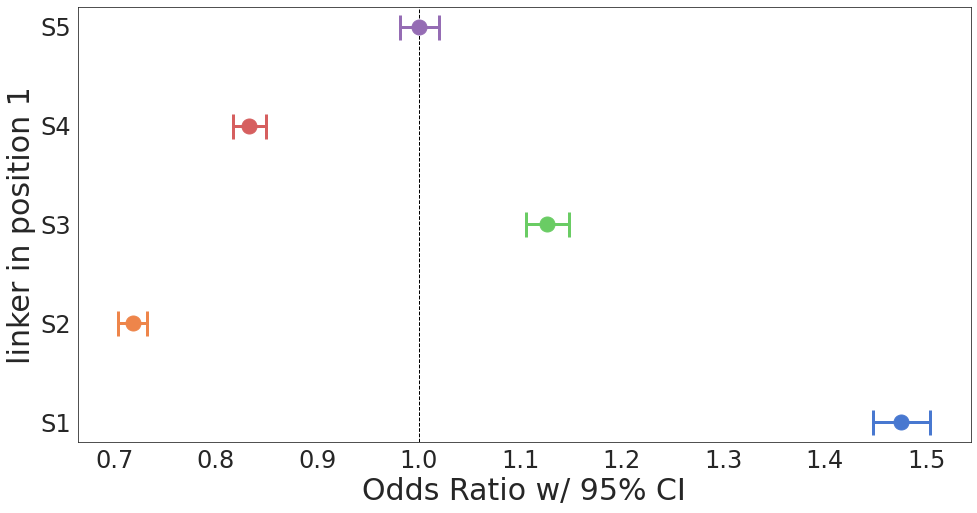

In [36]:
# Calculate the true odds ratios and plot them
odds_df = project_utils.odds_ratios(data=OLS_data, label="label", col=curr_pos)
project_utils.plot_odds_ratios(odds_df=odds_df, col=curr_pos, savefig="figs/odds_ratios/{}_{}_real-odds.png".format(PREPROCESS, curr_pos))